In [2]:
work_location = raw_input("Where are you working? ")
if work_location == 'remote':
    pwd = '/nfshome/nasurijr/delayed_jet_analyzer/'
elif work_location == 'desktop':
    pwd = '/home/cms/delayed_jet_analyzer/'

Where are you working? desktop


In [3]:
import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import collections
from collections import Counter, OrderedDict

import sys
sys.path.append(pwd+'lib')
# from histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list
from histo_utilities import create_TH1D, create_TH2D, std_color_list


# import CMS_lumi, tdrstyle
# tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 1
# CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

In [ ]:
# fpath = {}
fpath = OrderedDict()
# tree = {}
tree = OrderedDict()
# process = {}
# process_short = {}


#fpath['m50ct10000mm'] = '/Users/cmorgoth/llp_ntupler_gen_info.root'
fpath['qcd'] = pwd+'/data/jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root'
fpath['m50ct10000mm'] = pwd + '/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'

# Remote Work
# fpath['qcd'] = '/nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root'
# fpath['m50ct10000mm'] = '/nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'

# Local Work
# fpath['qcd'] = '/home/cms/delayed_jet_analyzer/data/jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root'
# fpath['m50ct10000mm'] = '/home/cms/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'

# MET+bb vH Datafile
#'/nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root'

# bbbb vH Datafile
#'/nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_bbbb_vh_ISR_mh125_mx50_pl1000_ev100000.root'


#process['glueBall'] = 'pp #rightarrow h*h* #rightarrow jj#nu#nu'
#process_short['glueBall'] = 'pp #rightarrow h*h* #rightarrow jj#nu#nu'

#print process
#print process_short


for k,v in fpath.items():
    print(k, v)
    tree[k] = rtnp.root2array(v)
    #tree[k] = rtnp.tree2array(v)
    #jet_max_pt_array = [np.max(x) for x in tree[k]["jetPt"]]
    a = tree[k]["gLLP_decay_vertex_z"]
    print(a[:-1][0])

In [63]:
#T = tree['glueBall']
T = tree['m50ct10000mm']
T_bkg = tree['qcd']

In [64]:
#get first jet pt per event
print(T['jetPt'])
first_jet_pt = [x[0] if len(x) else -1 for x in T['jetPt']]
#print first_jet_pt

[array([23.463825, 22.805841], dtype=float32)
 array([20.16013], dtype=float32) array([31.041063], dtype=float32) ...
 array([], dtype=float32) array([], dtype=float32)
 array([24.31063 , 22.433872], dtype=float32)]


In [65]:
x = np.arange(-5, 5, 1)
#print x
y = np.arange(-5, 5, 1)
xx, yy = np.meshgrid(x, y, sparse=True)
print(xx)
print(yy)

[[-5 -4 -3 -2 -1  0  1  2  3  4]]
[[-5]
 [-4]
 [-3]
 [-2]
 [-1]
 [ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]]


In [66]:
#get max jet pt per event
max_jet_pt = [np.max(np.abs(x)) if len(x) else -1 for x in T['gLLP_decay_vertex_z']]
#print max_jet_pt

In [67]:
#store jet-pt array per event in a list
first_jet_pt_arr = []
for x in T['jetPt']:
    if len(x) == 0:
        break
    #print x
    first_jet_pt_arr.append(x[0])

In [68]:
MAX_ITERATIONS = 100
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    return np.array_equal(oldCentroids,centroids) and iterations > 0


# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids, i):
    #print 1
    #for i in dataSet:
    dist = cdist( dataSet, centroids, metric='euclidean' )
    
    #print dist
    if i < 1:
        dist[dist>1.0] = 999
    elif i < 2:
        dist[dist>0.8] = 999
    else:
        dist[dist>0.4] = 999
        
    #print dist
    #print np.argmin(dist, axis=1)
    return np.argmin(dist, axis=1)
    #print dataSet
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.average(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getRandomCentroids():
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    even_list = np.linspace(-4.0, 4.0, num=5)
    centers  = np.empty((0,2))
    for i in even_list:
        for j in even_list:
            #print i,j
            new_arr = np.array([i,j])
            centers = np.append(centers,[new_arr],axis=0)
    #print centers
    return centers
    #return np.mgrid[-4:4.1:2, -4:4.1:2].reshape(2,-1).T
    #return np.random.rand(k,numFeatures)

# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmeans(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


0.9952842546502491


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: nCsc_dis (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nCsc_prompt (Potential memory leak).
Info in <TCanvas::Print>: pdf file ncsc_signal_vs_bkg.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ncsc_signal_vs_bkg.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: eta_phi_0 (Potential memory leak).
Info in <TCanvas::Print>: pdf file 2d_signal_event.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: 2d_signal_event.C has been generated


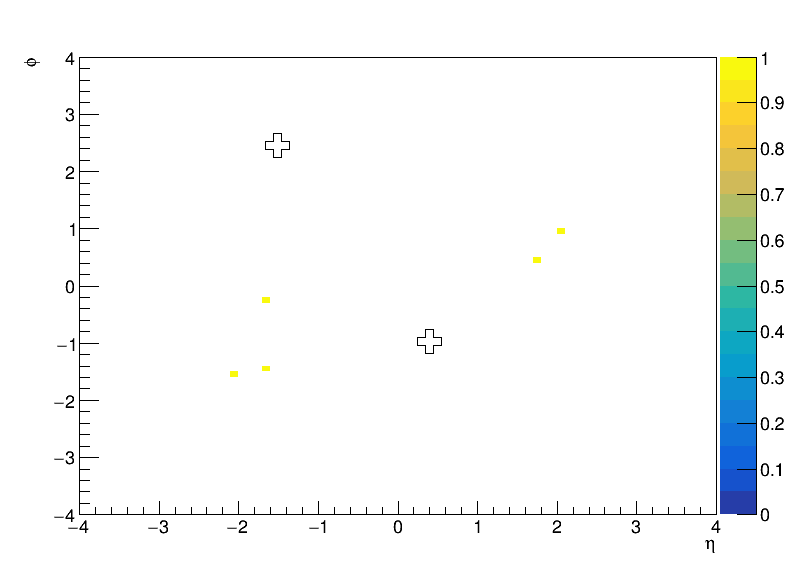

In [69]:
#Create Numpy Arrays for (['cscEta', 'cscPhi', 'cscX', 'cscY']) w
four_highest_jet_var = {}

#for v in ['jetPt', 'jetEta', 'jetPhi', 'jetE']:
#    tmp = []
#print T['gLLP_decay_vertex_z']
#print T['gLLP_decay_vertex_z'][:,0]

##ORIGINAL
# sel_dis1 = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) > 560, np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 1100)
# sel_dis1 = np.logical_and(, np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 100)
# sel_dis2 = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,1]) > 560, np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 1100, np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 100)

# Tested LLP bounds, 560, 300, 200
# Corrected sel_dis1 and sel_dis2 since np.logical_and only takes 2 arguments and therefore was not selecting properly

gLLP_r_0 = np.sqrt((T['gLLP_decay_vertex_x'][:,0])**2+(T['gLLP_decay_vertex_y'][:,0])**2)

# if fpath['m50ct10000mm'] == '/nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root':
if 'metbb' in fpath['m50ct10000mm']:
    sel_displaced = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) > 568 , np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 1100)
    sel_displaced = np.logical_and(sel_displaced, np.absolute(T['gLLP_eta'][:,0])<2.4)
    sel_displaced = np.logical_and(sel_displaced, np.absolute(T['gLLP_eta'][:,0])>0.9)
    sel_displaced = np.logical_and(sel_displaced, np.absolute(gLLP_r_0)<695.5)
    
    gLLPz_sel = T['gLLP_decay_vertex_z'][:,0][sel_displaced]
    nCsc_dis_sel = T['nCsc'][sel_displaced]

if 'bbbb' in fpath['m50ct10000mm']:  
# if fpath['m50ct10000mm'] == '/nfshome/nasurijr/delayed_jet_analyzer/data/jet_timing_studies_ntuple_bbbb_vh_ISR_mh125_mx50_pl1000_ev100000.root':
    sel_dis1 = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) > 300 , np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 1100)
    sel_dis1 = np.logical_and(sel_dis1, np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 100)
    sel_dis2 = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,1]) > 300 , np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 1100)
    sel_dis2 = np.logical_and(sel_dis1, np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 100)


    sel_dis3 = np.sqrt(T['gLLP_decay_vertex_x'][:,0]*T['gLLP_decay_vertex_x'][:,0] + T['gLLP_decay_vertex_y'][:,0]*T['gLLP_decay_vertex_y'][:,0]) < 100
    sel_dis4 = np.sqrt(T['gLLP_decay_vertex_x'][:,1]*T['gLLP_decay_vertex_x'][:,1] + T['gLLP_decay_vertex_y'][:,1]*T['gLLP_decay_vertex_y'][:,1]) < 100
    sel_dis12 = np.logical_or(sel_dis1,sel_dis2)
    sel_dis34 = np.logical_and(sel_dis3,sel_dis4)
    
    sel_displaced = sel_dis12
    
    # Used for making nCsc:gLLP_decay_vertex_z plots (c4)
    nCsc_dis_1 = T['nCsc'][sel_dis1]
    nCsc_dis_2 = T['nCsc'][sel_dis2]
    #print(type(nCsc_dis_1))
    nCsc_dis_sel = np.concatenate((nCsc_dis_1, nCsc_dis_2))
    #print(nCsc_dis_sel.shape)

    gLLPz_dis_1 = T['gLLP_decay_vertex_z'][:,0][sel_dis1]
    gLLPz_dis_2 = T['gLLP_decay_vertex_z'][:,1][sel_dis2]
    gLLPz_sel = np.concatenate((gLLPz_dis_1, gLLPz_dis_2))

sel_prompt = [True if np.any(x > 50) else False for x in T_bkg['jetPt']]

# Scrapped since the problem lied with understanding np.any()
# Test code for sel_prompt (broken apart for convenience)
# sel_prompt = []
# for x in T_bkg['jetPt']:
#     if np.any(x) > 50:
#         sel_prompt.append(True)
#     else:
#         sel_prompt.append(False)

eventNum_dis = T['eventNum'][sel_displaced]
lumiNum_dis = T['lumiNum'][sel_displaced]

csc_eta_dis = T['cscEta'][sel_displaced]
csc_phi_dis = T['cscPhi'][sel_displaced]
csc_x_dis = T['cscX'][sel_displaced]
csc_y_dis = T['cscY'][sel_displaced]
csc_z_dis = T['cscZ'][sel_displaced]
nCsc_dis = T['nCsc'][sel_displaced]

# # Used for making nCsc:gLLP_decay_vertex_z plots (c4)
# nCsc_dis_1 = T['nCsc'][sel_dis1]
# nCsc_dis_2 = T['nCsc'][sel_dis2]
# #print(type(nCsc_dis_1))
# nCsc_dis_sel = np.concatenate((nCsc_dis_1, nCsc_dis_2))
# #print(nCsc_dis_sel.shape)

# gLLPz_dis_1 = T['gLLP_decay_vertex_z'][:,0][sel_dis1]
# gLLPz_dis_2 = T['gLLP_decay_vertex_z'][:,1][sel_dis2]
# gLLPz_sel = np.concatenate((gLLPz_dis_1, gLLPz_dis_2))

eventNum_prompt = T_bkg['eventNum'][sel_prompt]
lumiNum_prompt = T_bkg['lumiNum'][sel_prompt]


# Addition for timing RMS plot (c3)
csc_t_dis = T['cscT'][sel_displaced]
cscT_dis_rms = [np.sqrt(np.mean(y**2)) if np.isnan(np.sqrt(np.mean(y**2)))==False else 0.0 for y in csc_t_dis]


csc_eta_prompt = T_bkg['cscEta'][sel_prompt]
csc_phi_prompt = T_bkg['cscPhi'][sel_prompt]
csc_x_prompt = T_bkg['cscX'][sel_prompt]
csc_y_prompt = T_bkg['cscY'][sel_prompt]
csc_z_prompt = T_bkg['cscZ'][sel_prompt]
nCsc_prompt = T_bkg['nCsc'][sel_prompt]

# Addition for timing RMS plot (c3)
csc_t_prompt = T_bkg['cscT'][sel_prompt]
cscT_prompt_rms = [np.sqrt(np.mean(y**2)) if np.isnan(np.sqrt(np.mean(y**2)))==False else 0.0 for y in csc_t_prompt]



#print nCsc_dis.ndim, nCsc_dis.shape, nCsc_dis.size
#print np.vstack((csc_eta_dis[0],csc_phi_dis[0])).T.ndim
evt_idx = 5
c = rt.TCanvas('c','c', 800, 600)
h = {}
h['nCsc_dis'] = create_TH1D(nCsc_dis, axis_title=['nCsc_dis', 'Events'], name='nCsc_dis', binning=[150,0,500])
h['nCsc_dis'].SetLineColor(4)
h['nCsc_prompt'] = create_TH1D(nCsc_prompt, axis_title=['nCsc_prompt', 'Events'], name='nCsc_prompt', binning=[150,0,500])
h['nCsc_prompt'].SetLineColor(2)
c.SetLogy()
#h['llp_eta'].SetStats(0)
h['nCsc_dis'].Scale(1.0/h['nCsc_dis'].Integral())
# print(h['nCsc_dis'].Scale(1.0/h['nCsc_dis'].Integral()))
h['nCsc_prompt'].Scale(1.0/h['nCsc_prompt'].Integral())
h['nCsc_dis'].SetLineWidth(2)
h['nCsc_prompt'].SetLineWidth(2)
h['nCsc_dis'].GetXaxis().SetRangeUser(0,200)
h['nCsc_prompt'].GetXaxis().SetRangeUser(0,200)
h['nCsc_dis'].SetLineWidth(2)
h['nCsc_prompt'].SetLineWidth(2)
h['nCsc_prompt'].SetStats(0)
h['nCsc_prompt'].SetTitle("")
h['nCsc_prompt'].SetXTitle("N_{csc}")

print(h['nCsc_dis'].Integral())

h['nCsc_prompt'].Draw('histo')
h['nCsc_dis'].Draw('histo+same')
h['nCsc_prompt'].Draw('histo+same')
# print(h['nCsc_dis'].Integral())

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nCsc_dis'], "Signal" , "L");
legend.AddEntry( h['nCsc_prompt'], "Bkg." , "L");
legend.Draw();

## Scrapped due to np.logical_and discovery
# Framework for identifying events by eventNum in ROOT TBrowser and event dump
# Sample hard-coding
#event4 = np.logical_and(T['eventNum'][sel_displaced]==4, T['nCsc'][sel_displaced]==21)
#print(event4.shape)
#print(csc_eta_dis[event4])

#c.Draw()
c.SaveAs("ncsc_signal_vs_bkg.pdf")
c.SaveAs("ncsc_signal_vs_bkg.C")

#print h['nCsc_prompt'].Integral(15,250)
#print h['nCsc_dis'].Integral(15,250)

c1 = rt.TCanvas('c1','c1', 800, 600)
h['eta_phi_0'] = create_TH2D(np.vstack((csc_eta_prompt[evt_idx],csc_phi_prompt[evt_idx])).T, name='eta_phi_0', title='', binning=[80, -4, 4, 80, -4, 4], weights=None, axis_title = ['#eta','#phi', ''])

## Scrapped due to np.logical_and discovery
# Resulting implementation of eventNum
#h['eta_phi_0'] = create_TH2D(np.vstack((csc_eta_dis[event4][0],csc_phi_dis[event4][0])).T, name='eta_phi_0', title='', binning=[80, -4, 4, 80, -4, 4], weights=None, axis_title = ['#eta','#phi', ''])


c1.SetLogy(0)
h['eta_phi_0'].SetStats(0)
c1.cd()
#h['eta_phi_0'].SetStats(0)
h['eta_phi_0'].Draw("colz")


#test_dataset = np.vstack((csc_eta_prompt[evt_idx],csc_phi_prompt[evt_idx])).T

test_dataset = np.vstack((csc_eta_dis[evt_idx],csc_phi_dis[evt_idx])).T
#print(test_dataset)
#print test_dataset.ndim
#print len(csc_eta_prompt[evt_idx])
centroids_t,centroid_constituents_t = kmeans(test_dataset,25)

ll  = 0
xx = []
yy = []
nn = 0
for nc in centroid_constituents_t:
    if nc > 0:
        nn += 1
        xx.append(centroids_t[ll,0])
        yy.append(centroids_t[ll,1])
    ll += 1
    

tg = rt.TGraph(nn)
for ii in range(nn):
    tg.SetPoint(ii,xx[ii],yy[ii])


tg.SetMarkerSize(3)
tg.SetMarkerStyle(28)
tg.Draw("P0+same")
        

#print(centroids_t)
#print(centroid_constituents_t)

total_hits = 0
for cc in centroid_constituents_t:
    if cc > 5:
        total_hits += cc
        

#print(total_hits)
    
#print(np.amax(centroid_constituents_t))
#print len(csc_eta_prompt[evt_idx])


c1.Draw()
c1.SaveAs("2d_signal_event.pdf")
c1.SaveAs("2d_signal_event.C")
    


In [70]:
# n_min_prompt = {}
# n_min_prompt['total'] = []

# n_max_prompt = {}
# n_max_prompt['total'] = []

# n_c_total_prompt = {}
# n_c_total_prompt['total'] = []

# z_min_pos_prompt = {}
# z_min_pos_prompt['total'] = []

# z_max_occ_prompt = {}
# z_max_occ_prompt['total'] = []

# z_max_occ_prompt_freq = {}
# z_max_occ_prompt_freq['total'] = []

# ms_roi_prompt = {}
# ms_roi_prompt['total'] = []

# csc_sections = [1,2,3,4,5]
# for section in csc_sections:
#     n_min_prompt[section] = []
#     n_max_prompt[section] = []
#     n_c_total_prompt[section] = []
#     z_min_pos_prompt[section] = []
#     z_max_occ_prompt[section] = []
#     z_max_occ_prompt_freq[section] = []
#     ms_roi_prompt[section] = []


# def prompt_clustering(station):
#     eta_data_prompt = data_prompt[station][0]
#     phi_data_prompt = data_prompt[station][1]
#     z_data_prompt = data_prompt[station][2]
#     test_dataset = np.vstack((eta_data_prompt, phi_data_prompt)).T
#     centroids, centroid_constituents = kmeans(test_dataset, 25)

#     # Centroid_constituents is a list of all of the hits corresponding to each centroid
#     # etaPhi_labels is a list of the centroids corresponding to each hit

#     etaPhi_labels = getLabels(test_dataset, centroids, 2)

#     # Determines nCsc for all clusters
#     total_hits = 0
#     for cc in centroid_constituents:
#         if cc > 3:
#             total_hits += cc
    
#     #n_c_total_prompt[station] = []
#     n_c_total_prompt[station].append(total_hits)
# #     n_c_total_prompt.append(total_hits)

#     #n_max_prompt[station] = []
#     n_max_prompt[station].append(np.amax(centroid_constituents))
# #     n_max_prompt.append(np.amax(centroid_constituents))

#     #n_min_prompt[station] = []
#     n_min_prompt[station].append(np.amin(centroid_constituents))
# #     n_min_prompt.append(np.amin(centroid_constituents))
    
#     # Determines the number of clusters or RoIs in the event/station
#     roi_s = 0
#     for c_hit in centroid_constituents:
#         if c_hit > 3:
#             roi_s += 1
    
#     #ms_roi_prompt[station] = []
#     ms_roi_prompt[station].append(roi_s)
# #     ms_roi_prompt.append(roi_s)

#     # Extracts minimum z position and most frequently hit z position
#     #z_pos = csc_z_prompt[prompt_event] # Old code for no z-clustering
#     z_arr = []
#     for cluster in range(len(etaPhi_labels)):
#         if np.count_nonzero(etaPhi_labels == etaPhi_labels[cluster]) > 3:
#             z_indices = [i for i,x in enumerate(etaPhi_labels) if x==etaPhi_labels[cluster]]
#             for index in z_indices:
#                 #z_arr.append(z_pos[index])
#                 z_arr.append(z_data_prompt[index])

#     z_final = np.asarray(z_arr[:int(total_hits)])
    
#     if z_final.shape[0] == 0:
#         z_final = np.append(z_final, float('nan'))
        
#     #z_min_pos_prompt[station] = []
#     if np.amin(z_final) > 0:
#         z_min_pos_prompt[station].append(z_final[np.where(z_final > 0, z_final, np.inf).argmin()])
# #         z_min_pos_prompt.append(z_final[np.where(z_final > 0, z_final, np.inf).argmin()])
#     else:
#         z_min_pos_prompt[station].append(z_final[np.where(z_final > 0, z_final, -np.inf).argmax()])
# #         z_min_pos_prompt.append(z_final[np.where(z_final > 0, z_final, -np.inf).argmax()])

#     if Counter(z_final).most_common(1)[0][1]>3:
#         #z_max_occ_prompt[station] = []
#         z_max_occ_prompt[station].append(Counter(z_final).most_common(1)[0][0])
# #         z_max_occ_prompt.append(Counter(z_final).most_common(1)[0][0])
#         indexZ = Counter(z_final).most_common(1)[0][0]
#         #z_max_occ_prompt_freq[station] = []
#         z_max_occ_prompt_freq[station].append(Counter(z_final).most_common(1)[0])    
# #         z_max_occ_prompt_freq.append(Counter(z_final).most_common(1)[0])
# #     return n_min_prompt, n_max_prompt, n_c_total_prompt, z_min_pos_prompt, z_max_occ_prompt, z_max_occ_prompt_freq, ms_roi_prompt
#     else:
#         z_max_occ_prompt[station].append(float('nan'))
#         z_max_occ_prompt_freq[station].append(float('nan'))

# for prompt_event in range(csc_eta_prompt.shape[0]):

#     data_prompt = {}
  
#     # 1/1 if 568 < zPos < 632:
#     hits_1_prompt = np.logical_or(np.logical_and(csc_z_prompt[prompt_event]<632, csc_z_prompt[prompt_event]>568), np.logical_and(csc_z_prompt[prompt_event]>-632, csc_z_prompt[prompt_event]<-568))
#     data_prompt[1] = (csc_eta_prompt[prompt_event][hits_1_prompt], csc_phi_prompt[prompt_event][hits_1_prompt], csc_z_prompt[prompt_event][hits_1_prompt])

    
#     # 1/2 and 1/3 elif 663 < zPos < 724:
#     hits_2_prompt = np.logical_or(np.logical_and(csc_z_prompt[prompt_event]<724, csc_z_prompt[prompt_event]>663), np.logical_and(csc_z_prompt[prompt_event]>-724, csc_z_prompt[prompt_event]<-663))
# #     hits_2_prompt = np.logical_and(csc_z_prompt[prompt_event]<724, csc_z_prompt[prompt_event]>663)
#     data_prompt[2] = (csc_eta_prompt[prompt_event][hits_2_prompt], csc_phi_prompt[prompt_event][hits_2_prompt], csc_z_prompt[prompt_event][hits_2_prompt])

    
#     # 2/1 and 2/2 elif 791 < zPos < 849.5:
#     hits_3_prompt = np.logical_or(np.logical_and(csc_z_prompt[prompt_event]<849.5, csc_z_prompt[prompt_event]>791), np.logical_and(csc_z_prompt[prompt_event]>-849.5, csc_z_prompt[prompt_event]<-791))
# #     hits_3_prompt = np.logical_and(csc_z_prompt[prompt_event]<849.5, csc_z_prompt[prompt_event]>791)
#     data_prompt[3] = (csc_eta_prompt[prompt_event][hits_3_prompt], csc_phi_prompt[prompt_event][hits_3_prompt], csc_z_prompt[prompt_event][hits_3_prompt])

    
#     # 3/1 and 3/2 elif 911.5 < zPos < 970:
#     hits_4_prompt = np.logical_or(np.logical_and(csc_z_prompt[prompt_event]<970, csc_z_prompt[prompt_event]>911.5), np.logical_and(csc_z_prompt[prompt_event]>-970, csc_z_prompt[prompt_event]<-911.5))
# #     hits_4_prompt = np.logical_and(csc_z_prompt[prompt_event]<970, csc_z_prompt[prompt_event]>911.5)
#     data_prompt[4] = (csc_eta_prompt[prompt_event][hits_4_prompt], csc_phi_prompt[prompt_event][hits_4_prompt], csc_z_prompt[prompt_event][hits_4_prompt])
    
#     # 4/1 and 4/2 elif 1002 < zPos < 1060.5:
#     hits_5_prompt = np.logical_or(np.logical_and(csc_z_prompt[prompt_event]<1060.5, csc_z_prompt[prompt_event]>1002.5), np.logical_and(csc_z_prompt[prompt_event]>-1060.5, csc_z_prompt[prompt_event]<-1002.5))
# #     hits_5_prompt = np.logical_and(csc_z_prompt[prompt_event]<1060.5, csc_z_prompt[prompt_event]>1002.5)
#     data_prompt[5] = (csc_eta_prompt[prompt_event][hits_5_prompt], csc_phi_prompt[prompt_event][hits_5_prompt], csc_z_prompt[prompt_event][hits_5_prompt])
    
#     prompt_clustering(1)
#     prompt_clustering(2)
#     prompt_clustering(3)
#     prompt_clustering(4)
#     prompt_clustering(5)
    
#     ncsc_temp = 0.0
#     ms_roi_temp = 0.0
#     z_freq_temp = np.array([])
#     z_max_temp = np.array([])
    
#     for x in csc_sections:
#         ncsc_temp += n_c_total_prompt[x][-1]
#         ms_roi_temp += ms_roi_prompt[x][-1]
# #         print(z_max_occ_prompt_freq[x][-1:])
#         np.append(z_freq_temp, z_max_occ_prompt_freq[x][-1:][0:][1:])
#         np.append(z_max_temp, z_max_occ_prompt[x][-1:])
# #         z_max_temp.append(z_max_occ_prompt[x][-1:])

#     n_c_total_prompt['total'].append(ncsc_temp)
#     ms_roi_prompt['total'].append(ms_roi_temp)

#     z_min_pos_prompt_event = float('nan')
#     for y in csc_sections:
#         if np.isnan(z_min_pos_prompt[y][-1]) == False:
#             z_min_pos_prompt_event = z_min_pos_prompt[y][-1]
#             break
#     z_min_pos_prompt['total'].append(z_min_pos_prompt_event)
  

#     if z_freq_temp.size != 0:
#         max_freq = np.amax(z_freq_temp[np.nonzero(z_freq_temp)])
#         max_freq_index = np.where(a==max_freq)
#         max_z_pos = z_max_temp[max_freq_index]
    
#         z_max_occ_prompt_freq['total'].append(max_freq)
        
#         z_max_occ_prompt['total'].append(max_z_pos)
#     else:
#         z_max_occ_prompt_freq['total'].append(float('nan'))
#         z_max_occ_prompt['total'].append(float('nan'))


In [71]:
n_min_prompt = {}
n_min_prompt['total'] = []

n_max_prompt = {}
n_max_prompt['total'] = []

n_c_total_prompt = {}
n_c_total_prompt['total'] = []

z_min_pos_prompt = {}
z_min_pos_prompt['total'] = []

z_max_occ_prompt = {}
z_max_occ_prompt['total'] = []

z_max_occ_prompt_freq = {}
z_max_occ_prompt_freq['total'] = []

ms_roi_prompt = {}
ms_roi_prompt['total'] = []

csc_sections = [1,2,3,4,5, -1, -2, -3, -4, -5]
for section in csc_sections:
    n_min_prompt[section] = []
    n_max_prompt[section] = []
    n_c_total_prompt[section] = []
    z_min_pos_prompt[section] = []
    z_max_occ_prompt[section] = []
    z_max_occ_prompt_freq[section] = []
    ms_roi_prompt[section] = []


def prompt_clustering(station):
    eta_data_prompt = data_prompt[station][0]
    phi_data_prompt = data_prompt[station][1]
    z_data_prompt = data_prompt[station][2]
    test_dataset = np.vstack((eta_data_prompt, phi_data_prompt)).T
    centroids, centroid_constituents = kmeans(test_dataset, 25)

    # Centroid_constituents is a list of all of the hits corresponding to each centroid
    # etaPhi_labels is a list of the centroids corresponding to each hit

    etaPhi_labels = getLabels(test_dataset, centroids, 2)

    # Determines nCsc for all clusters
    total_hits = 0
    for cc in centroid_constituents:
        if cc > 3:
            total_hits += cc
    
    n_c_total_prompt[station].append(total_hits)
    n_max_prompt[station].append(np.amax(centroid_constituents))
    n_min_prompt[station].append(np.amin(centroid_constituents))
    
    # Determines the number of clusters or RoIs in the event/station
    roi_s = 0
    for c_hit in centroid_constituents:
        if c_hit > 3:
            roi_s += 1
    
    ms_roi_prompt[station].append(roi_s)

    # Extracts minimum z position and most frequently hit z position
    z_final = np.array([])
    cluster_freq = np.array([])

    for cluster in np.unique(etaPhi_labels):
        if np.count_nonzero(etaPhi_labels == cluster) > 3:
#             z_indices = [i for i,x in enumerate(etaPhi_labels) if x==etaPhi_labels[cluster]]
#             for index in z_indices:
#                 z_arr.append(z_data_prompt[index])
            z_final = np.append(z_final, z_data_prompt[etaPhi_labels == cluster])
            cluster_freq = np.append(cluster_freq, centroid_constituents[cluster])

    
#     print(z_final.shape[0])
    if z_final.shape[0] == 0:
        z_final = np.append(z_final, np.nan)
        # Append nan to z_max, z_min
        z_min_pos_prompt[station].append(np.nan)
        z_max_occ_prompt[station].append(np.nan)
        z_max_occ_prompt_freq[station].append(np.nan)

    else:
        if np.amin(z_final) > 0:
            z_min_pos_prompt[station].append(z_final[np.where(z_final > 0, z_final, np.inf).argmin()])
        else:
            z_min_pos_prompt[station].append(z_final[np.where(z_final > 0, z_final, -np.inf).argmax()])

#         z_max_occ_prompt[station].append(Counter(z_final).most_common(1)[0][0])
#         indexZ = Counter(z_final).most_common(1)[0]
#         z_max_occ_prompt_freq[station].append(Counter(z_final).most_common(1)[0][1])

        max_cluster_freq = np.amax(cluster_freq)
        
        z_max_occ_prompt_freq[station].append(max_cluster_freq)
        indexZ = np.where(cluster_freq == max_cluster_freq)

        max_avg_z_occ = np.mean(z_final[indexZ])
        z_max_occ_prompt[station].append(max_avg_z_occ)

#         else:
#             z_max_occ_prompt[station].append(float('nan'))
#             z_max_occ_prompt_freq[station].append(float('nan'))
    #         gLLPz_pos = gLLPz_sel[prompt_event]
#     print(Counter(z_final).most_common(1)[0])
#     print(z_max_occ_prompt[station])
for prompt_event in range(csc_eta_prompt.shape[0]):

    data_prompt = {}
  
    # 1/1 if 568 < zPos < 632:
    hits_pos1_prompt = np.logical_and(csc_z_prompt[prompt_event]<632, csc_z_prompt[prompt_event]>568)
    hits_neg1_prompt = np.logical_and(csc_z_prompt[prompt_event]>-632, csc_z_prompt[prompt_event]<-568)
    data_prompt[1] = (csc_eta_prompt[prompt_event][hits_pos1_prompt], csc_phi_prompt[prompt_event][hits_pos1_prompt], csc_z_prompt[prompt_event][hits_pos1_prompt])
    data_prompt[-1] = (csc_eta_prompt[prompt_event][hits_neg1_prompt], csc_phi_prompt[prompt_event][hits_neg1_prompt], csc_z_prompt[prompt_event][hits_neg1_prompt])
    
    
    # 1/2 and 1/3 elif 663 < zPos < 724:
#     hits_2_prompt = np.logical_or(np.logical_and(csc_z_prompt[prompt_event]<724, csc_z_prompt[prompt_event]>663), np.logical_and(csc_z_prompt[prompt_event]>-724, csc_z_prompt[prompt_event]<-663))
    hits_pos2_prompt = np.logical_and(csc_z_prompt[prompt_event]<724, csc_z_prompt[prompt_event]>663)
    hits_neg2_prompt = np.logical_and(csc_z_prompt[prompt_event]>-724, csc_z_prompt[prompt_event]<-663)
    data_prompt[2] = (csc_eta_prompt[prompt_event][hits_pos2_prompt], csc_phi_prompt[prompt_event][hits_pos2_prompt], csc_z_prompt[prompt_event][hits_pos2_prompt])
    data_prompt[-2] = (csc_eta_prompt[prompt_event][hits_neg2_prompt], csc_phi_prompt[prompt_event][hits_neg2_prompt], csc_z_prompt[prompt_event][hits_neg2_prompt])

    
    # 2/1 and 2/2 elif 791 < zPos < 849.5:
#     hits_3_prompt = np.logical_or(np.logical_and(csc_z_prompt[prompt_event]<849.5, csc_z_prompt[prompt_event]>791), np.logical_and(csc_z_prompt[prompt_event]>-849.5, csc_z_prompt[prompt_event]<-791))
    hits_pos3_prompt = np.logical_and(csc_z_prompt[prompt_event]<849.5, csc_z_prompt[prompt_event]>791)
    hits_neg3_prompt = np.logical_and(csc_z_prompt[prompt_event]>-849.5, csc_z_prompt[prompt_event]<-791)
    data_prompt[3] = (csc_eta_prompt[prompt_event][hits_pos3_prompt], csc_phi_prompt[prompt_event][hits_pos3_prompt], csc_z_prompt[prompt_event][hits_pos3_prompt])
    data_prompt[-3] = (csc_eta_prompt[prompt_event][hits_pos3_prompt], csc_phi_prompt[prompt_event][hits_pos3_prompt], csc_z_prompt[prompt_event][hits_pos3_prompt])

    
    # 3/1 and 3/2 elif 911.5 < zPos < 970:
#     hits_4_prompt = np.logical_or(np.logical_and(csc_z_prompt[prompt_event]<970, csc_z_prompt[prompt_event]>911.5), np.logical_and(csc_z_prompt[prompt_event]>-970, csc_z_prompt[prompt_event]<-911.5))
    hits_pos4_prompt = np.logical_and(csc_z_prompt[prompt_event]<970, csc_z_prompt[prompt_event]>911.5)
    hits_neg4_prompt = np.logical_and(csc_z_prompt[prompt_event]>-970, csc_z_prompt[prompt_event]<-911.5)
    data_prompt[4] = (csc_eta_prompt[prompt_event][hits_pos4_prompt], csc_phi_prompt[prompt_event][hits_pos4_prompt], csc_z_prompt[prompt_event][hits_pos4_prompt])
    data_prompt[-4] = (csc_eta_prompt[prompt_event][hits_neg4_prompt], csc_phi_prompt[prompt_event][hits_neg4_prompt], csc_z_prompt[prompt_event][hits_neg4_prompt])
    
    
    # 4/1 and 4/2 elif 1002 < zPos < 1060.5:
#     hits_5_prompt = np.logical_or(np.logical_and(csc_z_prompt[prompt_event]<1060.5, csc_z_prompt[prompt_event]>1002.5), np.logical_and(csc_z_prompt[prompt_event]>-1060.5, csc_z_prompt[prompt_event]<-1002.5))
    hits_pos5_prompt = np.logical_and(csc_z_prompt[prompt_event]<1060.5, csc_z_prompt[prompt_event]>1002.5)
    hits_neg5_prompt = np.logical_and(csc_z_prompt[prompt_event]>-1060.5, csc_z_prompt[prompt_event]<-1002.5)
    data_prompt[5] = (csc_eta_prompt[prompt_event][hits_pos5_prompt], csc_phi_prompt[prompt_event][hits_pos5_prompt], csc_z_prompt[prompt_event][hits_pos5_prompt])
    data_prompt[-5] = (csc_eta_prompt[prompt_event][hits_neg5_prompt], csc_phi_prompt[prompt_event][hits_neg5_prompt], csc_z_prompt[prompt_event][hits_neg5_prompt])
    
#     gLLPz_pos = float('nan')
    
    prompt_clustering(1)
    prompt_clustering(-1)
    prompt_clustering(2)
    prompt_clustering(-2)
    prompt_clustering(3)
    prompt_clustering(-3)
    prompt_clustering(4)
    prompt_clustering(-4)
    prompt_clustering(5)
    prompt_clustering(-5)
    
    ncsc_temp = 0.0
    ms_roi_temp = 0.0
    
    z_freq_temp = np.array([])
    z_max_temp = np.array([])
    
    for x in csc_sections:
        ncsc_temp += n_c_total_prompt[x][-1]
        ms_roi_temp += ms_roi_prompt[x][-1]
#         print(z_max_occ_prompt[x])
#         print(z_max_occ_prompt_freq[x][-1])
        z_freq_temp = np.append(z_freq_temp, z_max_occ_prompt_freq[x][-1])
#         print(z_max_occ_prompt_freq[x][-1][1])
        z_max_temp = np.append(z_max_temp, z_max_occ_prompt[x][-1])
#     print(z_freq_temp)

    n_c_total_prompt['total'].append(ncsc_temp)
    ms_roi_prompt['total'].append(ms_roi_temp)

    z_min_pos_prompt_event = np.nan
    for y in csc_sections:
        if np.isnan(z_min_pos_prompt[y][-1]) == False:
            z_min_pos_prompt_event = z_min_pos_prompt[y][-1]
            break
            
    if np.isnan(z_min_pos_prompt_event) == False:
        z_min_pos_prompt['total'].append(z_min_pos_prompt_event)
  
    if z_freq_temp.size == len(csc_sections):
        z_freq_temp = np.nan_to_num(z_freq_temp).astype(int)
#         print(z_freq_temp)
#         x.astype(int)
        max_freq = np.amax(z_freq_temp)
        max_freq_index = np.where(z_freq_temp == max_freq)
        max_z_pos = z_max_temp[max_freq_index][0]
#         print(max_z_pos)
        if np.isnan(max_z_pos) == False:
            z_max_occ_prompt['total'].append(max_z_pos)
    else:
        print("Function error")

In [115]:
n_min_dis = {}
n_min_dis['total'] = []

n_max_dis = {}
n_max_dis['total'] = []

n_c_total_dis = {}
n_c_total_dis['total'] = []

z_min_pos_dis = {}
z_min_pos_dis['total'] = []

z_max_occ_dis = {}
z_max_occ_dis['total'] = []

z_max_occ_dis_freq = {}
z_max_occ_dis_freq['total'] = []

ms_roi_dis = {}
ms_roi_dis['total'] = []

csc_sections = [1,2,3,4,5, -1, -2, -3, -4, -5]
for section in csc_sections:
    n_min_dis[section] = []
    n_max_dis[section] = []
    n_c_total_dis[section] = []
    z_min_pos_dis[section] = []
    z_max_occ_dis[section] = []
    z_max_occ_dis_freq[section] = []
    ms_roi_dis[section] = []
gLLPz = []
test_events = []
test_lumi = []


def dis_clustering(station):
    eta_data_dis = data_dis[station][0]
    phi_data_dis = data_dis[station][1]
    z_data_dis = data_dis[station][2]
    test_dataset = np.vstack((eta_data_dis, phi_data_dis)).T
    centroids, centroid_constituents = kmeans(test_dataset, 25)

    # Centroid_constituents is a list of all of the hits corresponding to each centroid
    # etaPhi_labels is a list of the centroids corresponding to each hit

    etaPhi_labels = getLabels(test_dataset, centroids, 2)

    # Determines nCsc for all clusters
    total_hits = 0
    for cc in centroid_constituents:
        if cc > 3:
            total_hits += cc
    
    n_c_total_dis[station].append(total_hits)
    n_max_dis[station].append(np.amax(centroid_constituents))
    n_min_dis[station].append(np.amin(centroid_constituents))
    
    # Determines the number of clusters or RoIs in the event/station
    roi_s = 0
    for c_hit in centroid_constituents:
        if c_hit > 3:
            roi_s += 1
    
    ms_roi_dis[station].append(roi_s)
#     print(centroid_constituents)
#     print(etaPhi_labels)
    # Extracts minimum z position and most frequently hit z position
    z_final = np.array([])
    cluster_freq = np.array([])
    for cluster in np.unique(etaPhi_labels):
        if np.count_nonzero(etaPhi_labels == cluster) > 3:
#             z_indices = [i for i,x in enumerate(etaPhi_labels) if x==etaPhi_labels[cluster]]
#             for index in z_indices:
#                 z_arr.append(z_data_dis[index])
            z_final = np.append(z_final, z_data_dis[etaPhi_labels == cluster])
            cluster_freq = np.append(cluster_freq, centroid_constituents[cluster])
        
#     print(cluster_freq)
#     print(z_final)
#     print(z_final)
    if z_final.shape[0] == 0:
        z_final = np.append(z_final, np.nan)
        # Append nan to z_max, z_min
        z_min_pos_dis[station].append(np.nan)
        z_max_occ_dis[station].append(np.nan)
        z_max_occ_dis_freq[station].append(np.nan)

    else:
        if np.amin(z_final) > 0:
            z_min_pos_dis[station].append(z_final[np.where(z_final > 0, z_final, np.inf).argmin()])
        else:
            z_min_pos_dis[station].append(z_final[np.where(z_final > 0, z_final, -np.inf).argmax()])

#         print(z_final[0])
#         print(Counter(z_final).most_common(1)[0][0])
#         z_max_occ_dis[station].append(Counter(z_final).most_common(1)[0][0])
#         indexZ = Counter(z_final).most_common(1)[0]
#         z_max_occ_dis_freq[station].append(Counter(z_final).most_common(1)[0][1])

        max_cluster_freq = np.amax(cluster_freq)
        
        z_max_occ_dis_freq[station].append(max_cluster_freq)
        indexZ = np.where(cluster_freq == max_cluster_freq)

        max_avg_z_occ = np.mean(z_final[indexZ])
        z_max_occ_dis[station].append(max_avg_z_occ)
        
#         else:
#             z_max_occ_dis[station].append(float('nan'))
#             z_max_occ_dis_freq[station].append(float('nan'))
    #         gLLPz_pos = gLLPz_sel[dis_event]
#     print(Counter(z_final).most_common(1)[0])
#     print(z_max_occ_dis[station])
for dis_event in range(csc_eta_dis.shape[0]):

    data_dis = {}
  
    # 1/1 if 568 < zPos < 632:
    hits_pos1_dis = np.logical_and(csc_z_dis[dis_event]<632, csc_z_dis[dis_event]>568)
    hits_neg1_dis = np.logical_and(csc_z_dis[dis_event]>-632, csc_z_dis[dis_event]<-568)
    data_dis[1] = (csc_eta_dis[dis_event][hits_pos1_dis], csc_phi_dis[dis_event][hits_pos1_dis], csc_z_dis[dis_event][hits_pos1_dis])
    data_dis[-1] = (csc_eta_dis[dis_event][hits_neg1_dis], csc_phi_dis[dis_event][hits_neg1_dis], csc_z_dis[dis_event][hits_neg1_dis])
    
    
    # 1/2 and 1/3 elif 663 < zPos < 724:
#     hits_2_dis = np.logical_or(np.logical_and(csc_z_dis[dis_event]<724, csc_z_dis[dis_event]>663), np.logical_and(csc_z_dis[dis_event]>-724, csc_z_dis[dis_event]<-663))
    hits_pos2_dis = np.logical_and(csc_z_dis[dis_event]<724, csc_z_dis[dis_event]>663)
    hits_neg2_dis = np.logical_and(csc_z_dis[dis_event]>-724, csc_z_dis[dis_event]<-663)
    data_dis[2] = (csc_eta_dis[dis_event][hits_pos2_dis], csc_phi_dis[dis_event][hits_pos2_dis], csc_z_dis[dis_event][hits_pos2_dis])
    data_dis[-2] = (csc_eta_dis[dis_event][hits_neg2_dis], csc_phi_dis[dis_event][hits_neg2_dis], csc_z_dis[dis_event][hits_neg2_dis])

    
    # 2/1 and 2/2 elif 791 < zPos < 849.5:
#     hits_3_dis = np.logical_or(np.logical_and(csc_z_dis[dis_event]<849.5, csc_z_dis[dis_event]>791), np.logical_and(csc_z_dis[dis_event]>-849.5, csc_z_dis[dis_event]<-791))
    hits_pos3_dis = np.logical_and(csc_z_dis[dis_event]<849.5, csc_z_dis[dis_event]>791)
    hits_neg3_dis = np.logical_and(csc_z_dis[dis_event]>-849.5, csc_z_dis[dis_event]<-791)
    data_dis[3] = (csc_eta_dis[dis_event][hits_pos3_dis], csc_phi_dis[dis_event][hits_pos3_dis], csc_z_dis[dis_event][hits_pos3_dis])
    data_dis[-3] = (csc_eta_dis[dis_event][hits_pos3_dis], csc_phi_dis[dis_event][hits_pos3_dis], csc_z_dis[dis_event][hits_pos3_dis])

    
    # 3/1 and 3/2 elif 911.5 < zPos < 970:
#     hits_4_dis = np.logical_or(np.logical_and(csc_z_dis[dis_event]<970, csc_z_dis[dis_event]>911.5), np.logical_and(csc_z_dis[dis_event]>-970, csc_z_dis[dis_event]<-911.5))
    hits_pos4_dis = np.logical_and(csc_z_dis[dis_event]<970, csc_z_dis[dis_event]>911.5)
    hits_neg4_dis = np.logical_and(csc_z_dis[dis_event]>-970, csc_z_dis[dis_event]<-911.5)
    data_dis[4] = (csc_eta_dis[dis_event][hits_pos4_dis], csc_phi_dis[dis_event][hits_pos4_dis], csc_z_dis[dis_event][hits_pos4_dis])
    data_dis[-4] = (csc_eta_dis[dis_event][hits_neg4_dis], csc_phi_dis[dis_event][hits_neg4_dis], csc_z_dis[dis_event][hits_neg4_dis])
    
    
    # 4/1 and 4/2 elif 1002 < zPos < 1060.5:
#     hits_5_dis = np.logical_or(np.logical_and(csc_z_dis[dis_event]<1060.5, csc_z_dis[dis_event]>1002.5), np.logical_and(csc_z_dis[dis_event]>-1060.5, csc_z_dis[dis_event]<-1002.5))
    hits_pos5_dis = np.logical_and(csc_z_dis[dis_event]<1060.5, csc_z_dis[dis_event]>1002.5)
    hits_neg5_dis = np.logical_and(csc_z_dis[dis_event]>-1060.5, csc_z_dis[dis_event]<-1002.5)
    data_dis[5] = (csc_eta_dis[dis_event][hits_pos5_dis], csc_phi_dis[dis_event][hits_pos5_dis], csc_z_dis[dis_event][hits_pos5_dis])
    data_dis[-5] = (csc_eta_dis[dis_event][hits_neg5_dis], csc_phi_dis[dis_event][hits_neg5_dis], csc_z_dis[dis_event][hits_neg5_dis])
    
#     gLLPz_pos = float('nan')
    
    dis_clustering(1)
    dis_clustering(-1)
    dis_clustering(2)
    dis_clustering(-2)
    dis_clustering(3)
    dis_clustering(-3)
    dis_clustering(4)
    dis_clustering(-4)
    dis_clustering(5)
    dis_clustering(-5)
    
    ncsc_temp = 0.0
    ms_roi_temp = 0.0
    
    z_freq_temp = np.array([])
    z_max_temp = np.array([])
    
    for x in csc_sections:
        ncsc_temp += n_c_total_dis[x][-1]
        ms_roi_temp += ms_roi_dis[x][-1]
#         print(z_max_occ_dis[x])
#         print(z_max_occ_dis_freq[x][-1])
        z_freq_temp = np.append(z_freq_temp, z_max_occ_dis_freq[x][-1])
#         print(z_max_occ_dis_freq[x][-1][1])
        z_max_temp = np.append(z_max_temp, z_max_occ_dis[x][-1])
#     print(z_freq_temp)

    n_c_total_dis['total'].append(ncsc_temp)
    ms_roi_dis['total'].append(ms_roi_temp)

    z_min_pos_dis_event = np.nan
    for y in csc_sections:
        if np.isnan(z_min_pos_dis[y][-1]) == False:
            z_min_pos_dis_event = z_min_pos_dis[y][-1]
            break
            
#     counter_z_max = 0      
    print(z_min_pos_dis_event)
    if np.isnan(z_min_pos_dis_event) == False:
        z_min_pos_dis['total'].append(z_min_pos_dis_event)
        gLLPz.append(gLLPz_sel[dis_event])
#         gLLPz.append(gLLPz_sel[dis_event])
        test_events.append(eventNum_dis[dis_event])
        test_lumi.append(lumiNum_dis[dis_event])
#     print('sou')
        
    
    if z_freq_temp.size == len(csc_sections):
        z_freq_temp = np.nan_to_num(z_freq_temp).astype(int)
#         print(z_freq_temp)
#         x.astype(int)
        max_freq = np.amax(z_freq_temp)
        max_freq_index = np.where(z_freq_temp == max_freq)
        max_z_pos = z_max_temp[max_freq_index][0]
#         print(max_z_pos)
        if np.isnan(max_z_pos) == False:
            z_max_occ_dis['total'].append(max_z_pos)
            
    else:
        print("Function error")

nan
-712.7216186523438
-695.0492553710938
-923.1023559570312
816.009033203125
nan
nan
-616.9918823242188
923.2196044921875
922.9154663085938
-948.0169067382812
nan
-923.0083618164062
nan
nan
nan
-947.8574829101562
-923.0449829101562
684.9710693359375
nan
-685.4159545898438
nan
-922.9991455078125
-616.9794311523438
nan
587.6663208007812
815.8292236328125
-1037.3302001953125
587.6649780273438
-587.5603637695312
587.6309814453125
-1037.3302001953125
922.5792846679688
nan
nan
-947.7971801757812
-923.176513671875
nan
-694.9448852539062
-694.9705200195312
nan
-587.713623046875
-616.9698486328125
nan
-685.482177734375
-694.9705200195312
-616.8914794921875
1012.4807739257812
-712.7546997070312
nan
684.9689331054688
-923.1217041015625
-1012.5301513671875
nan
816.0552978515625
695.1193237304688
947.5895385742188
nan
nan
nan
nan
587.7155151367188
-1012.3978881835938
nan
-947.8508911132812
923.1809692382812
nan
816.1873779296875
-712.7706298828125
947.5730590820312
947.9891967773438
nan
nan
-712.7

840.8472290039062
616.9338989257812
816.0855712890625
684.9241333007812
587.6610107421875
nan
-923.1946411132812
-617.03515625
-685.3973999023438
-947.9432373046875
816.0810546875
685.0256958007812
nan
-712.7923583984375
nan
1037.28076171875
nan
-1037.0926513671875
-616.9926147460938
695.0140991210938
-587.6779174804688
695.088623046875
1012.4807739257812
617.0216064453125
nan
-1037.1630859375
1037.28076171875
nan
684.9546508789062
nan
923.1610107421875
-923.1327514648438
695.2130126953125
nan
840.8222045898438
nan
684.9888916015625
816.0908203125
-1037.22900390625
-712.928466796875
815.89501953125
1012.6875610351562
684.8123779296875
923.232177734375
-923.058349609375
-1012.2662963867188
-694.9887084960938
587.5827026367188
816.0633544921875
816.0794067382812
nan
-1037.2113037109375
-587.618408203125
815.94091796875
1012.4807739257812
947.6168823242188
nan
nan
nan
840.6600952148438
587.7353515625
695.2445068359375
nan
-712.8217163085938
-923.076171875
815.9810180664062
nan
-1037.33020

nan
840.868408203125
684.9244384765625
922.8027954101562
587.7991333007812
1037.28076171875
840.82958984375
nan
-923.0533447265625
nan
nan
1012.7494506835938
nan
684.9977416992188
1012.4807739257812
922.8883056640625
587.679931640625
1037.28076171875
-923.0813598632812
-712.9052734375
nan
nan
617.002197265625
nan
nan
-712.75390625
-1012.4259033203125
587.7775268554688
587.7495727539062
nan
nan
815.8707885742188
-1012.5301513671875
840.7075805664062
816.16455078125
816.0646362304688
nan
nan
-947.7820434570312
587.7871704101562
-1037.3302001953125
695.0448608398438
-616.9683837890625
nan
-947.7711791992188
816.0025024414062
816.0465087890625
695.1009521484375
815.8702392578125
922.7896118164062
nan
695.0830688476562
nan
-695.0300903320312
922.6603393554688
685.015869140625
-587.665771484375
nan
815.8816528320312
-923.1646728515625
nan
923.22900390625
1012.4807739257812
nan
-685.4126586914062
695.1488647460938
nan
922.89892578125
nan
-923.171142578125
-616.9215087890625
587.7193603515625


816.0914306640625
nan
nan
nan
684.9169921875
1012.756591796875
684.977783203125
587.6238403320312
nan
-1012.5301513671875
nan
695.0775146484375
nan
684.9381103515625
-1012.4473876953125
-1037.3302001953125
923.1552734375
-694.9684448242188
-712.8192749023438
nan
-695.0109252929688
947.5912475585938
nan
nan
nan
1037.28076171875
923.2427368164062
616.913818359375
nan
nan
815.9169311523438
-587.5537109375
922.8876953125
-695.0090942382812
nan
617.08203125
684.88623046875
nan
-923.0662231445312
nan
1037.28076171875
816.0217895507812
nan
-923.26953125
695.2565307617188
840.8906860351562
695.1910400390625
922.803466796875
1037.4952392578125
587.6290893554688
816.0682373046875
nan
1012.4807739257812
-947.890625
1012.4807739257812
695.0870971679688
-712.6756591796875
-616.9898071289062
840.7628784179688
684.9596557617188
923.147705078125
nan
1012.5740966796875
nan
816.0338745117188
685.0250854492188
-685.5084838867188
-947.8291015625
nan
1012.6509399414062
-947.8444213867188
684.8494873046875


1037.28076171875
-923.0648803710938
-923.175048828125
-947.954345703125
nan
-1012.5301513671875
-948.1078491210938
-947.9000244140625
-587.6544189453125
-712.7076416015625
-947.8485717773438
-923.0732421875
nan
nan
-923.08154296875
840.6838989257812
-1012.5301513671875
816.003173828125
nan
1012.4807739257812
-923.300537109375
816.0047607421875
-616.8627319335938
-923.1622924804688
587.6111450195312
840.793212890625
816.0648803710938
nan
587.6948852539062
-694.9548950195312
684.8646240234375
923.2750244140625
923.2039794921875
nan
684.8823852539062
684.9120483398438
587.71826171875
nan
nan
-616.9395141601562
-712.7438354492188
nan
-712.7650756835938
nan
684.9859619140625
nan
815.7909545898438
nan
815.9422607421875
nan
nan
-947.7991943359375
-947.9856567382812
-617.0439453125
815.7710571289062
nan
-616.9497680664062
-947.87646484375
nan
-712.7529907226562
587.7245483398438
-712.689697265625
816.0869750976562
nan
684.8975830078125
nan
617.01220703125
-1012.5301513671875
-923.0603637695312

1012.5859375
nan
685.0283813476562
nan
815.914794921875
-694.9987182617188
-712.7017211914062
922.8143310546875
816.0455322265625
815.9417114257812
1012.6635131835938
815.8671875
-712.7650756835938
-947.9035034179688
-1037.3779296875
616.9154663085938
-947.8857421875
684.9495849609375
1012.7509765625
-1012.407958984375
-685.326171875
nan
nan
684.8289184570312
-947.769287109375
-1037.279052734375
587.6882934570312
nan
-1012.3303833007812
nan
-685.4864501953125
nan
-685.2914428710938
-947.7908325195312
684.8824462890625
922.8797607421875
-923.1297607421875
-712.7672729492188
-923.1734619140625
816.0664672851562
922.765625
-587.6939086914062
840.7322387695312
684.8275146484375
nan
nan
-1037.3302001953125
684.9757690429688
840.6932373046875
948.039306640625
-1012.3616943359375
-587.6702880859375
-712.7626342773438
816.1344604492188
1012.4807739257812
-947.9423217773438
-685.2056884765625
587.6103515625
695.2130126953125
-616.9827270507812
-947.779296875
-685.229736328125
684.9841918945312


587.6439819335938
815.9342651367188
-712.7559814453125
-587.551513671875
nan
922.644287109375
nan
587.573974609375
695.1967163085938
nan
nan
684.836181640625
816.05224609375
-947.9441528320312
947.6388549804688
684.8887939453125
-1037.3302001953125
nan
nan
nan
-947.8646240234375

KeyboardInterrupt: 

In [112]:
print(len(z_min_pos_dis['total']))
print(len(gLLPz))

3817
2792


In [73]:
# print(eventNum_prompt[np.array(n_c_total_prompt['total'])>50])
# print(lumiNum_prompt[np.array(n_c_total_prompt['total'])>50])
# # print(gLLPz_sel[np.array(n_c_total_dis['total'])==80])
# print(nCsc_prompt_sel[np.array(n_c_total_prompt['total'])>50])

# Identify odd events upper left...
index_event = np.where(np.logical_and(np.array(gLLPz)<0, np.array(z_min_pos_dis['total'])>0))
test_events = np.array(test_events)
print(test_events[index_event])

index_lumi = np.where(np.logical_and(np.array(gLLPz)<0, np.array(z_min_pos_dis['total'])>0))
test_lumi = np.array(test_lumi)
print(test_lumi[index_lumi])

eve_gTest = 355
lumi_gTest = 104
# eve_gTest = 950
# lumi_gTest = 130
print(np.array(n_c_total_dis['total'])[np.logical_and(eventNum_dis == eve_gTest, lumiNum_dis == lumi_gTest)])
print(np.array(nCsc_dis_sel)[np.logical_and(eventNum_dis == eve_gTest, lumiNum_dis == lumi_gTest)])
print(np.array(gLLPz_sel)[np.logical_and(eventNum_dis == eve_gTest, lumiNum_dis == lumi_gTest)])
print(np.array(z_min_pos_dis['total'])[np.logical_and(test_events == eve_gTest, test_lumi == lumi_gTest)])


# print(n_c_total_dis['total'][index_lumi])


# print(test_events[gLLPz_sel<0])
# print(test_lumi[gLLPz_sel<0])
# print(lumiNum_dis[np.array(n_c_total_dis['total'])==80])

# print(np.array([80, 80]/nCsc_dis_sel[np.array(n_c_total_dis['total'])==80]))
# print(n_c_total_dis['total']/nCsc_dis_sel)

[973 237 935 552 176  91 371 998 877 647 106  41 140 845 779 903 966 557
 791 362 388  59 349 397 644 896 693 592 357 759 982 735 507 969 337 259
  90  91 258 786 149 313 755 247 543 570 940  44 670  93 183 737 702 570
 705 784 814 715 270  55 760 101  79  17 715 766 902 617 857 268 495 738
 399 678 674 937 349 216 438 954 994 614 753 439 543 809 796 200 616 760
 162 384 864 173 268 246 555 563 904  37 961 330 559 914 104 584 823  64
 150 342 127 426 387 354 317]
[  10  993 1000  106  112  121  124  130  139  147  162  891  892  899
  908  910  910  926  928  934  934  941  954  954  957  969  977  986
  174  178   20  198  206  210  214  223  231  241  243  248  252  254
  258  263  266  276  280  281   27  291  302  308  318  336  338  338
  349  358  373  381  408  422  431  441  448  458  460  467  469  473
  475  478  494  497  547  550  564  583   55   60   60  617  618  635
  646  649  658  662  667  688   62   64  699  702  743  763  766  766
  770  771  780  784  806  810  812

In [74]:
signal_cluster_eff = np.nan_to_num(n_c_total_dis['total'])/nCsc_dis_sel
bkg_cluster_eff = n_c_total_prompt['total']/nCsc_prompt

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0.9952842546502491


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TROOT::Append>: Replacing existing TH1: nmax_dis (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nmax_prompt (Potential memory leak).
Info in <TCanvas::Print>: pdf file muon_roi_trigger_bkg_like.pdf has been created
Info in <TCanvas::Print>: pdf file muon_roi_trigger_signal_like.pdf has been created
Info in <TCanvas::Print>: pdf file muon_roi_trigger_signal_vs_bkg.pdf has been created


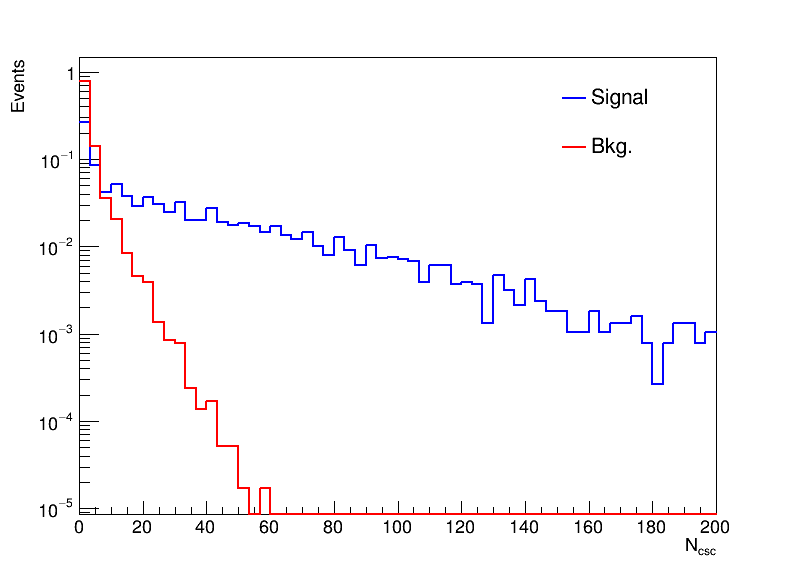

In [75]:
c2 = rt.TCanvas('c2','c2', 800, 600)
h['nmax_dis'] = create_TH1D(n_c_total_dis['total'], axis_title=['nCsc_dis', 'Events'], name='nmax_dis', binning=[150,0,500])
# Replace 5 with 'total'
h['nmax_dis'].SetLineColor(4)
#h['nmax_prompt'] = create_TH1D(n_c_total_prompt, axis_title=['nmax_prompt', 'Events'], name='nmax_prompt', binning=[250,0,500])
h['nmax_prompt'] = create_TH1D(n_c_total_prompt['total'], axis_title=['nmax_prompt', 'Events'], name='nmax_prompt', binning=[150,0,500])

h['nmax_prompt'].SetLineColor(2)
c2.SetLogy()
#h['llp_eta'].SetStats(0)
h['nmax_dis'].Scale(1.0/h['nmax_dis'].Integral())
h['nmax_prompt'].Scale(1.0/h['nmax_prompt'].Integral())
h['nCsc_dis'].SetLineColor(8)
h['nCsc_prompt'].SetLineColor(6)

#HISTO INFO
#print(h['nmax_prompt'].Integral(10,250))
#print(h['nmax_dis'].Integral(10,250))

#DRAW HISTOGRAMS
h['nmax_prompt'].GetXaxis().SetRangeUser(0,200)
h['nmax_prompt'].Draw('histo')
#h['nmax_dis'].Draw('histo+same')
#h['nCsc_dis'].Draw('histo+same')
h['nCsc_prompt'].Draw('histo+same')

c2.Draw()
c2.SaveAs("muon_roi_trigger_bkg_like.pdf")

h['nmax_dis'].GetXaxis().SetRangeUser(0,200)
h['nmax_dis'].SetLineColor(2)
h['nCsc_dis'].SetLineColor(6)
h['nmax_dis'].Draw('histo')
h['nCsc_dis'].Draw('histo+same')
c2.SaveAs("muon_roi_trigger_signal_like.pdf")

h['nmax_dis'].GetXaxis().SetRangeUser(0,200)
h['nmax_dis'].SetLineColor(4)
h['nmax_prompt'].SetLineColor(2)
h['nmax_dis'].SetLineWidth(2)
h['nmax_prompt'].SetLineWidth(2)
h['nmax_prompt'].SetStats(0)
h['nmax_prompt'].SetTitle("")
h['nmax_prompt'].SetXTitle("N_{csc}")

print(h['nCsc_dis'].Integral())

h['nmax_prompt'].Draw('histo')
h['nmax_dis'].Draw('histo+same')
h['nmax_prompt'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nmax_dis'], "Signal" , "L");
legend.AddEntry( h['nmax_prompt'], "Bkg." , "L");
legend.Draw();

c2.SaveAs("muon_roi_trigger_signal_vs_bkg.pdf")

# print(h['nCsc_dis'].Integral())

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Warning in <TROOT::Append>: Replacing existing TH1: cscT_dis_rms (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: cscT_prompt_rms (Potential memory leak).
Info in <TCanvas::Print>: pdf file cscT_rms_signal_vs_bkg.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: cscT_rms_signal_vs_bkg.C has been generated


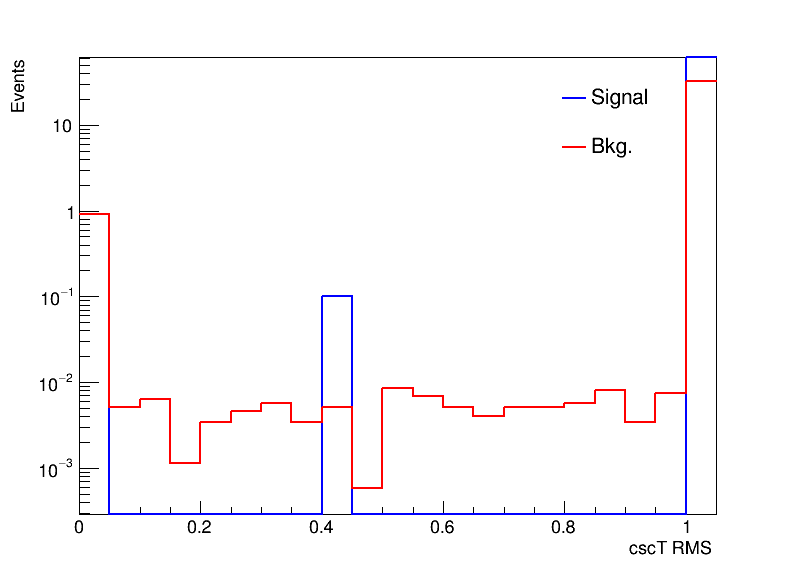

In [76]:
# cscTiming RMS plot for QCD/vH samples

c3 = rt.TCanvas('c3','c3', 800, 600)
h['cscT_dis_rms'] = create_TH1D(cscT_dis_rms, axis_title=['cscT_dis_rms', 'Events'], name='cscT_dis_rms', binning=[20, 0, 1])
h['cscT_dis_rms'].SetLineColor(4)

h['cscT_prompt_rms'] = create_TH1D(cscT_prompt_rms, axis_title=['cscT_prompt_rms', 'Events'], name='cscT_prompt_rms', binning=[20, 0, 1])
h['cscT_prompt_rms'].SetLineColor(2)

c3.SetLogy()

h['cscT_dis_rms'].Scale(1.0/h['cscT_dis_rms'].Integral())
h['cscT_prompt_rms'].Scale(1.0/h['cscT_prompt_rms'].Integral())

#h['cscT_dis_rms'].SetLineWidth(2)
#h['cscT_prompt_rms'].SetLineWidth(2)
h['cscT_dis_rms'].GetXaxis().SetRangeUser(0,200)
h['cscT_prompt_rms'].GetXaxis().SetRangeUser(0,200)
h['cscT_dis_rms'].SetLineWidth(2)
h['cscT_prompt_rms'].SetLineWidth(2)
h['cscT_prompt_rms'].SetStats(0)
h['cscT_prompt_rms'].SetTitle("")
h['cscT_prompt_rms'].SetXTitle("cscT RMS")
h['cscT_prompt_rms'].Draw('histo')
h['cscT_dis_rms'].Draw('histo+same')
h['cscT_prompt_rms'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['cscT_dis_rms'], "Signal" , "L");
legend.AddEntry( h['cscT_prompt_rms'], "Bkg." , "L");
legend.Draw();

c3.Draw()
c3.SaveAs("cscT_rms_signal_vs_bkg.pdf")
c3.SaveAs("cscT_rms_signal_vs_bkg.C")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
Warning in <TROOT::Append>: Replacing existing TH1: nCsc_gLLPz_0 (Potential memory leak).
Info in <TCanvas::Print>: pdf file nCsc_gLLPdecayVertZ.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: nCsc_gLLPdecayVertZ.C has been generated


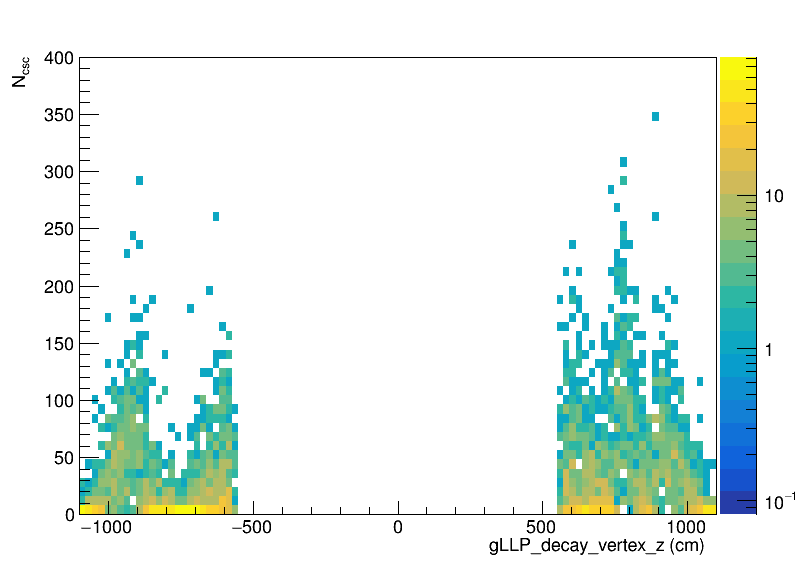

In [102]:
# nCsc:gLLP_decay_vertex_z plot for QCD/vH 

c4 = rt.TCanvas('c4','c4', 800, 600)

# Plots unclustered version of nCsc:gLLP_decay_vertex_z
#h['nCsc_gLLPz_0'] = create_TH2D(np.vstack((gLLPz_sel, nCsc_dis_sel)).T, name='nCsc_gLLPz_0', title='Pre-clustering Version', binning=[100, -1100, 1100, 50, 0, 400], axis_title=['gLLP_decay_vertex_z (cm)', 'N_{csc}', ''])

# Plots clustered version of nCsc:gLLP_decay_vertex_z
h['nCsc_gLLPz_0'] = create_TH2D(np.vstack((gLLPz_sel, n_c_total_dis['total'])).T, name='nCsc_gLLPz_0', binning=[100, -1100, 1100, 50, 0, 400], axis_title=['gLLP_decay_vertex_z (cm)', 'N_{csc}', ''])

c4.SetLogz()
h['nCsc_gLLPz_0'].SetStats(0)
h['nCsc_gLLPz_0'].SetTitle('')
#c4.cd()
#h['eta_phi_0'].SetStats(0)
h['nCsc_gLLPz_0'].Draw("colz")
c4.Draw()
c4.SaveAs("nCsc_gLLPdecayVertZ.pdf")
c4.SaveAs("nCsc_gLLPdecayVertZ.C")

In [103]:
# minZ_pos:gLLP_decay_vertex_z plot for QCD/vH 

c5 = rt.TCanvas('c5','c5', 800, 500)

# Plots clustered version of nCsc:gLLP_decay_vertex_z
h['minZ_pos_gLLPz_0'] = create_TH2D(np.vstack((gLLPz, z_min_pos_dis['total'])).T, name='minZ_pos_gLLPz_0', binning=[100, -1100, 1100, 100, -1100, 1100], axis_title=['gLLP_decay_vertex_z (cm)', 'Minimum Z Position (cm)', ''])
c5.SetLogz()
h['minZ_pos_gLLPz_0'].SetStats(0)
h['minZ_pos_gLLPz_0'].SetTitle('')
#c4.cd()
#h['eta_phi_0'].SetStats(0)
h['minZ_pos_gLLPz_0'].Draw("colz")
c5.Draw()
#c5.SaveAs("nCsc_gLLPdecayVertZ.pdf")
#c5.SaveAs("nCsc_gLLPdecayVertZ.C")

ValueError: all the input array dimensions except for the concatenation axis must match exactly

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5


In [95]:
print(len(gLLPz))
print(len(z_min_pos_dis['total']))

2800
2800


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c6
Warning in <TROOT::Append>: Replacing existing TH1: maxZ_occ_gLLPz_0 (Potential memory leak).


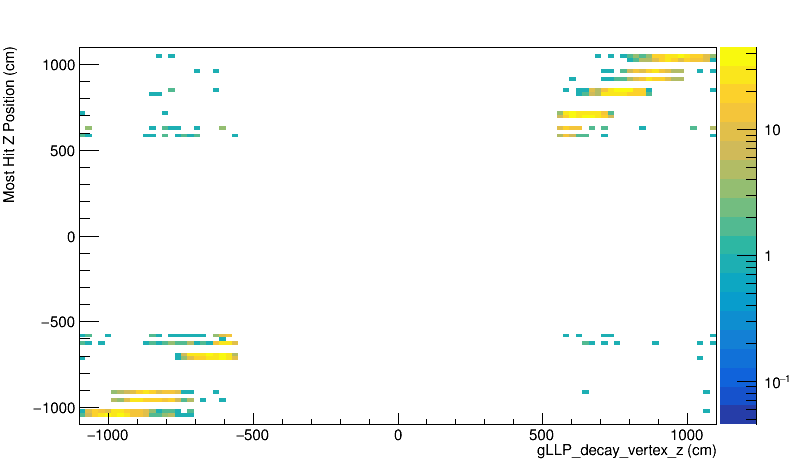

In [104]:
# maxZ_occ:gLLP_decay_vertex_z plot for QCD/vH 

c6 = rt.TCanvas('c6','c6', 800, 500)

# Plots clustered version of nCsc:gLLP_decay_vertex_z
h['maxZ_occ_gLLPz_0'] = create_TH2D(np.vstack((gLLPz, z_max_occ_dis['total'])).T, name='maxZ_occ_gLLPz_0', binning=[100, -1100, 1100, 100, -1100, 1100], axis_title=['gLLP_decay_vertex_z (cm)', 'Most Hit Z Position (cm)', ''])
c6.SetLogz()
h['maxZ_occ_gLLPz_0'].SetStats(0)
h['maxZ_occ_gLLPz_0'].SetTitle('')
#c4.cd()
#h['eta_phi_0'].SetStats(0)
h['maxZ_occ_gLLPz_0'].Draw("colz")
c6.Draw()
#c5.SaveAs("nCsc_gLLPdecayVertZ.pdf")
#c5.SaveAs("nCsc_gLLPdecayVertZ.C")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c7
Warning in <TROOT::Append>: Replacing existing TH1: muon_roi (Potential memory leak).


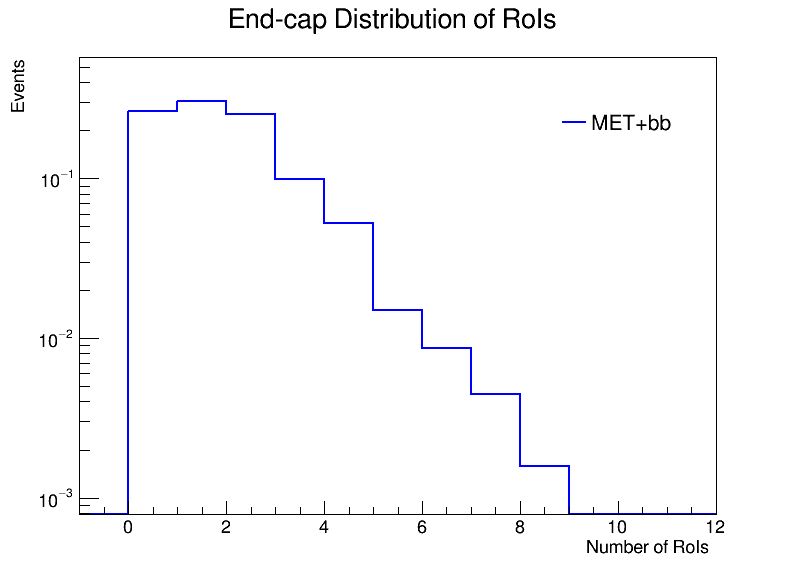

In [83]:
c7 = rt.TCanvas('c7','c7', 800, 600)

h['muon_roi'] = create_TH1D(ms_roi_dis['total'], axis_title=['Number of RoIs', 'Events'], name='muon_roi', title='End-cap Distribution of RoIs', binning=[15, 0, 15])
h['muon_roi'].SetLineColor(4)
# cscT_prompt_rms
c7.SetLogy()

h['muon_roi'].Scale(1.0/h['muon_roi'].Integral())

#h['cscT_dis_rms'].SetLineWidth(2)
#h['cscT_prompt_rms'].SetLineWidth(2)
#h['cscT_dis_rms'].GetXaxis().SetRangeUser(0,20)
h['muon_roi'].GetXaxis().SetRangeUser(-1,12)
#h['cscT_dis_rms'].SetLineWidth(2)
h['muon_roi'].SetLineWidth(2)
h['muon_roi'].SetStats(0)
h['muon_roi'].Draw('histo')
#h['cscT_dis_rms'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
#legend.AddEntry( h['cscT_dis_rms'], "Signal" , "L");
legend.AddEntry( h['muon_roi'], "MET+bb", 'l');
legend.Draw();

c7.Draw()

In [84]:
# print(z_max_occ_dis['total'].shape)
print(len(z_min_pos_dis['total']))
print(len(z_max_occ_dis['total']))
print(len(ms_roi_dis['total']))
print(len(n_c_total_dis['total']))

2800
2792
3817
3817


In [85]:
temp = np.where(np.logical_and(np.array(z_max_occ_prompt['total'])<500, np.array(z_max_occ_prompt['total'])>-500))
print(np.array(z_max_occ_prompt['total'])[temp])

# index_event = np.where(np.logical_and(np.array(gLLPz)<0, np.array(z_min_pos_dis['total'])>0))
# test_events = np.array(test_events)
# print(test_events[index_event])


[]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c9
Warning in <TROOT::Append>: Replacing existing TH1: maxZ_ggH (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: maxZ_QCD (Potential memory leak).


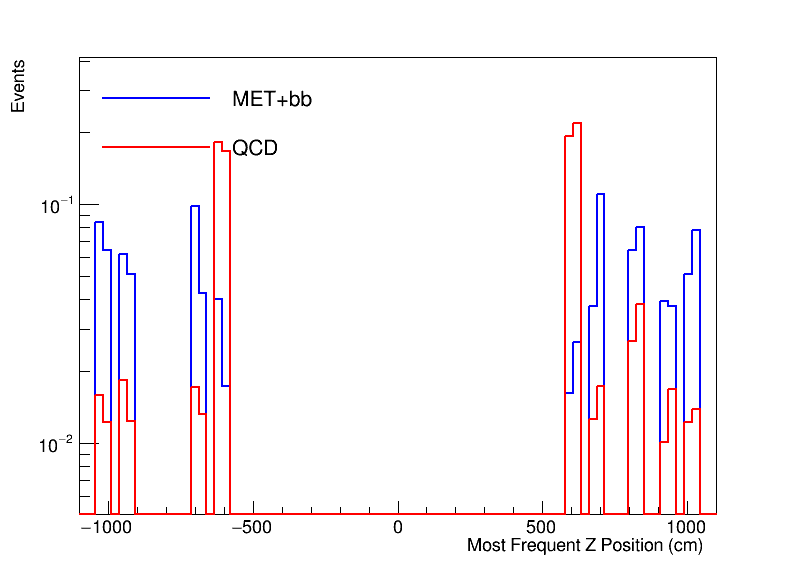

In [116]:
c9 = rt.TCanvas('c9','c9', 800, 600)

h['maxZ_ggH'] = create_TH1D(z_max_occ_dis['total'], axis_title=['Minimum Z Position (cm)', 'Events'], name='maxZ_ggH', binning=[80, -1100, 1100])
h['maxZ_ggH'].SetLineColor(4)

h['maxZ_QCD'] = create_TH1D(z_max_occ_prompt['total'], axis_title=['Most Frequent Z Position (cm)', 'Events'], name='maxZ_QCD', binning=[80, -1100, 1100])
h['maxZ_QCD'].SetLineColor(2)
# cscT_prompt_rms
c9.SetLogy()

h['maxZ_ggH'].Scale(1.0/h['maxZ_ggH'].Integral())
h['maxZ_QCD'].Scale(1.0/h['maxZ_QCD'].Integral())

h['maxZ_ggH'].GetXaxis().SetRangeUser(-1100,1100)
h['maxZ_QCD'].GetXaxis().SetRangeUser(-1100,1100)
h['maxZ_ggH'].SetLineWidth(2)
h['maxZ_QCD'].SetLineWidth(2)
h['maxZ_QCD'].SetStats(0)
h['maxZ_QCD'].SetTitle("")
# h['max_z_QCD'].SetXTitle("cscT RMS")
h['maxZ_QCD'].Draw('histo')
h['maxZ_ggH'].Draw('histo+same')
h['maxZ_QCD'].Draw('histo+same')

legend = rt.TLegend(0.1,0.7,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
#legend.AddEntry( h['cscT_dis_rms'], "Signal" , "L");
legend.AddEntry( h['maxZ_ggH'], "MET+bb", 'l');
legend.AddEntry( h['maxZ_QCD'], "QCD", 'l');
legend.Draw();

c9.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c10
Warning in <TROOT::Append>: Replacing existing TH1: min_z_ggH (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: min_z_QCD (Potential memory leak).


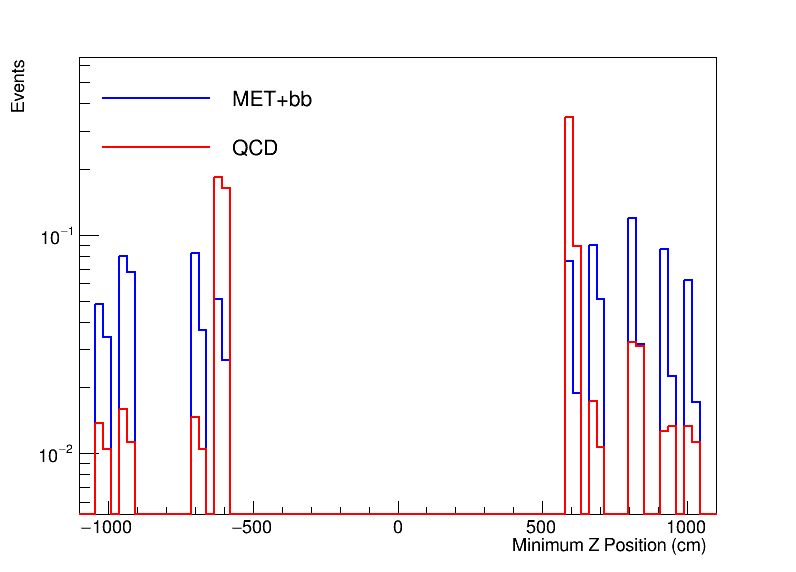

In [87]:
c10 = rt.TCanvas('c10','c10', 800, 600)

h['min_z_ggH'] = create_TH1D(z_min_pos_dis['total'], axis_title=['Minimum Z Position (cm)', 'Events'], name='min_z_ggH', binning=[80, -1100, 1100])
h['min_z_ggH'].SetLineColor(4)

h['max_z_QCD'] = create_TH1D(z_min_pos_prompt['total'], axis_title=['Minimum Z Position (cm)', 'Events'], name='min_z_QCD', binning=[80, -1100, 1100])
h['max_z_QCD'].SetLineColor(2)
# cscT_prompt_rms
c10.SetLogy()

h['min_z_ggH'].Scale(1.0/h['min_z_ggH'].Integral())
h['max_z_QCD'].Scale(1.0/h['max_z_QCD'].Integral())

h['min_z_ggH'].GetXaxis().SetRangeUser(-1100,1100)
h['max_z_QCD'].GetXaxis().SetRangeUser(-1100,1100)
h['min_z_ggH'].SetLineWidth(2)
h['max_z_QCD'].SetLineWidth(2)
h['max_z_QCD'].SetStats(0)
h['max_z_QCD'].SetTitle("")
# h['max_z_QCD'].SetXTitle("cscT RMS")
h['max_z_QCD'].Draw('histo')
h['min_z_ggH'].Draw('histo+same')
h['max_z_QCD'].Draw('histo+same')

legend = rt.TLegend(0.1,0.7,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
#legend.AddEntry( h['cscT_dis_rms'], "Signal" , "L");
legend.AddEntry( h['min_z_ggH'], "MET+bb", 'l');
legend.AddEntry( h['max_z_QCD'], "QCD", 'l');
legend.Draw();

c10.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c11
Warning in <TROOT::Append>: Replacing existing TH1: muon_roi (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: muon_roi_prompt (Potential memory leak).


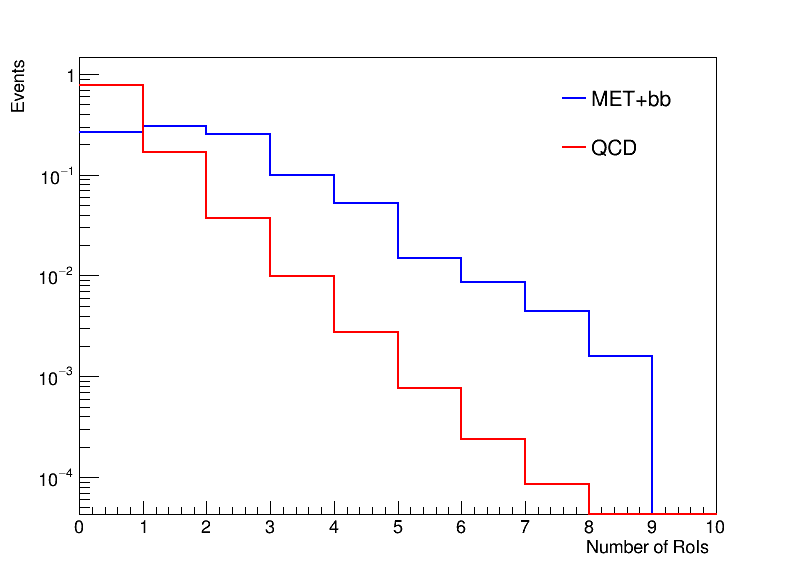

In [88]:
c11 = rt.TCanvas('c11','c11', 800, 600)

h['muon_roi'] = create_TH1D(ms_roi_dis['total'], axis_title=['Number of RoIs', 'Events'], name='muon_roi', title='End-cap Distribution of RoIs', binning=[15, 0, 15])
h['muon_roi'].SetLineColor(4)

h['muon_roi_prompt'] = create_TH1D(ms_roi_prompt['total'], axis_title=['Number of RoIs', 'Events'], name='muon_roi_prompt', title='End-cap Distribution of RoIs', binning=[15, 0, 15])
h['muon_roi_prompt'].SetLineColor(2)
# cscT_prompt_rms
c11.SetLogy()

h['muon_roi'].Scale(1.0/h['muon_roi'].Integral())
h['muon_roi_prompt'].Scale(1.0/h['muon_roi_prompt'].Integral())

h['muon_roi'].GetXaxis().SetRangeUser(0,10)
h['muon_roi_prompt'].GetXaxis().SetRangeUser(0,10)
h['muon_roi'].SetLineWidth(2)
h['muon_roi_prompt'].SetLineWidth(2)
h['muon_roi_prompt'].SetStats(0)
h['muon_roi_prompt'].SetTitle("")
# h['max_z_QCD'].SetXTitle("cscT RMS")
h['muon_roi_prompt'].Draw('histo')
h['muon_roi'].Draw('histo+same')
h['muon_roi_prompt'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['muon_roi'], "MET+bb" , "L");
legend.AddEntry( h['muon_roi_prompt'], "QCD", 'l');
legend.Draw();

c11.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c12
Warning in <TROOT::Append>: Replacing existing TH1: muon_roi_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: muon_roi_2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: muon_roi_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: muon_roi_4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: muon_roi_5 (Potential memory leak).


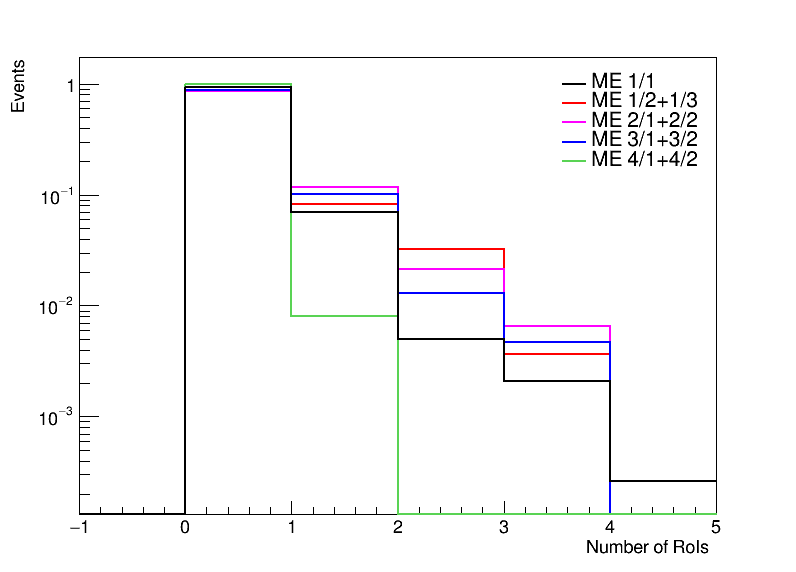

In [89]:
c12 = rt.TCanvas('c12','c12', 800, 600)

h['muon_roi_1'] = create_TH1D(ms_roi_dis[1], axis_title=['Number of RoIs', 'Events'], name='muon_roi_1', title='End-cap Distribution of RoIs', binning=[4, 0, 4])
h['muon_roi_1'].SetLineColor(1)

h['muon_roi_2'] = create_TH1D(ms_roi_dis[2], axis_title=['Number of RoIs', 'Events'], name='muon_roi_2', title='End-cap Distribution of RoIs', binning=[4, 0, 4])
h['muon_roi_2'].SetLineColor(2)

h['muon_roi_3'] = create_TH1D(ms_roi_dis[3], axis_title=['Number of RoIs', 'Events'], name='muon_roi_3', title='End-cap Distribution of RoIs', binning=[4, 0, 4])
h['muon_roi_3'].SetLineColor(6)

h['muon_roi_4'] = create_TH1D(ms_roi_dis[4], axis_title=['Number of RoIs', 'Events'], name='muon_roi_4', title='End-cap Distribution of RoIs', binning=[4, 0, 4])
h['muon_roi_4'].SetLineColor(4)

h['muon_roi_5'] = create_TH1D(ms_roi_prompt[5], axis_title=['Number of RoIs', 'Events'], name='muon_roi_5', title='End-cap Distribution of RoIs', binning=[4, 0, 4])
h['muon_roi_5'].SetLineColor(8)
# cscT_prompt_rms
c12.SetLogy()

h['muon_roi_1'].Scale(1.0/h['muon_roi_1'].Integral())
h['muon_roi_2'].Scale(1.0/h['muon_roi_2'].Integral())
h['muon_roi_3'].Scale(1.0/h['muon_roi_3'].Integral())
h['muon_roi_4'].Scale(1.0/h['muon_roi_4'].Integral())
h['muon_roi_5'].Scale(1.0/h['muon_roi_5'].Integral())

# h['muon_roi_prompt'].Scale(1.0/h['muon_roi_prompt'].Integral())
h['muon_roi_1'].GetXaxis().SetRangeUser(-1100,1100)
h['muon_roi_2'].GetXaxis().SetRangeUser(-1100,1100)
h['muon_roi_3'].GetXaxis().SetRangeUser(-1100,1100)
h['muon_roi_4'].GetXaxis().SetRangeUser(-1100,1100)
h['muon_roi_5'].GetXaxis().SetRangeUser(-1100,1100)


# h['muon_roi'].GetXaxis().SetRangeUser(-1100,1100)
# h['muon_roi_prompt'].GetXaxis().SetRangeUser(-1100,1100)
# h['muon_roi'].SetLineWidth(2)
# h['muon_roi_prompt'].SetLineWidth(2)
h['muon_roi_1'].SetLineWidth(2)
h['muon_roi_2'].SetLineWidth(2)
h['muon_roi_3'].SetLineWidth(2)
h['muon_roi_4'].SetLineWidth(2)
h['muon_roi_5'].SetLineWidth(2)

h['muon_roi_1'].SetStats(0)
# h['muon_roi_2'].SetStats(0)
# h['muon_roi_3'].SetStats(0)
# h['muon_roi_4'].SetStats(0)
# h['muon_roi_5'].SetStats(0)

# h['muon_roi_prompt'].SetStats(0)
h['muon_roi_1'].SetTitle("")
# h['max_z_QCD'].SetXTitle("cscT RMS")
h['muon_roi_1'].Draw('histo')
h['muon_roi_2'].Draw('histo+same')
h['muon_roi_3'].Draw('histo+same')
h['muon_roi_4'].Draw('histo+same')
h['muon_roi_5'].Draw('histo+same')
h['muon_roi_1'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['muon_roi_1'], "ME 1/1" , "L");
legend.AddEntry( h['muon_roi_2'], "ME 1/2+1/3" , "L");
legend.AddEntry( h['muon_roi_3'], "ME 2/1+2/2" , "L");
legend.AddEntry( h['muon_roi_4'], "ME 3/1+3/2" , "L");
legend.AddEntry( h['muon_roi_5'], "ME 4/1+4/2" , "L");
legend.Draw();

c12.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c13
Warning in <TROOT::Append>: Replacing existing TH1: min_z_ggH (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: min_z_QCD (Potential memory leak).


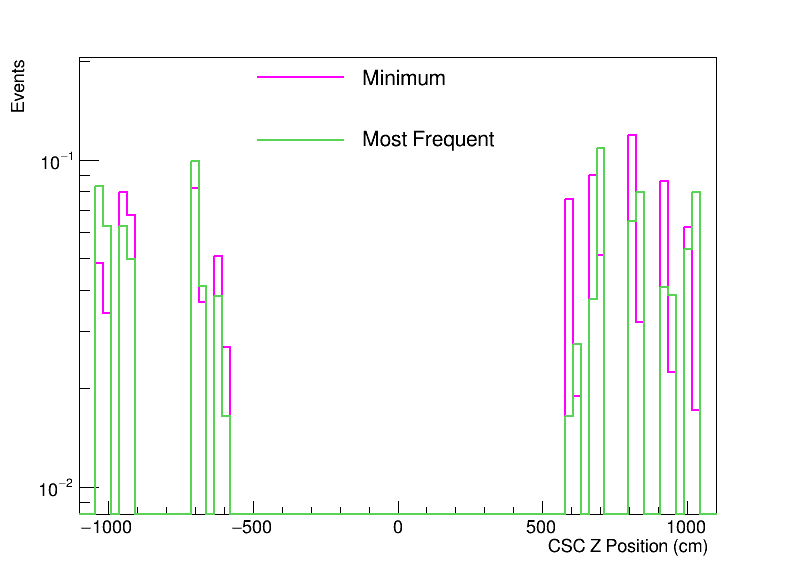

In [90]:
c13 = rt.TCanvas('c13','c13', 800, 600)

h['min_z_ggH'] = create_TH1D(z_min_pos_dis['total'], axis_title=['Minimum Z Position (cm)', 'Events'], name='min_z_ggH', binning=[80, -1100, 1100])
h['min_z_ggH'].SetLineColor(6)

h['max_z_QCD'] = create_TH1D(z_max_occ_dis['total'], axis_title=['CSC Z Position (cm)', 'Events'], name='min_z_QCD', binning=[80, -1100, 1100])
h['max_z_QCD'].SetLineColor(8)
# cscT_prompt_rms
c13.SetLogy()

h['min_z_ggH'].Scale(1.0/h['min_z_ggH'].Integral())
h['max_z_QCD'].Scale(1.0/h['max_z_QCD'].Integral())

h['min_z_ggH'].GetXaxis().SetRangeUser(-1100,1100)
h['max_z_QCD'].GetXaxis().SetRangeUser(-1100,1100)
h['min_z_ggH'].SetLineWidth(2)
h['max_z_QCD'].SetLineWidth(2)
h['max_z_QCD'].SetStats(0)
h['max_z_QCD'].SetTitle("")
# h['max_z_QCD'].SetXTitle("cscT RMS")
h['max_z_QCD'].Draw('histo')
h['min_z_ggH'].Draw('histo+same')
h['max_z_QCD'].Draw('histo+same')

legend = rt.TLegend(0.3,0.7,0.92,0.92);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
#legend.AddEntry( h['cscT_dis_rms'], "Signal" , "L");
legend.AddEntry( h['min_z_ggH'], "Minimum", 'l');
legend.AddEntry( h['max_z_QCD'], "Most Frequent", 'l');
legend.Draw();

c13.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c14
Warning in <TROOT::Append>: Replacing existing TH1: signal_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bkg_eff (Potential memory leak).


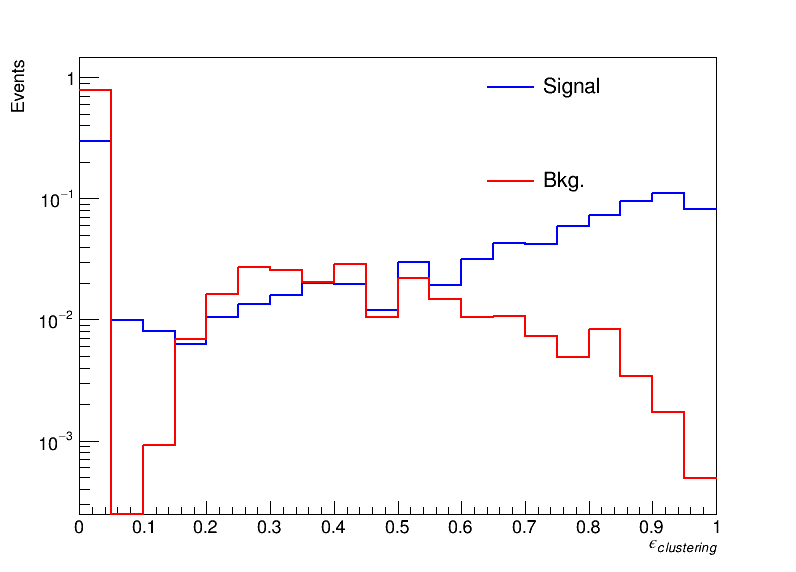

In [91]:
# Clustering efficiency for signal/bkg

c14 = rt.TCanvas('c14','c14', 800, 600)
h['signal_eff'] = create_TH1D(np.nan_to_num(signal_cluster_eff), axis_title=['signal_eff', 'Events'], name='signal_eff', binning=[20,0,1])
h['signal_eff'].SetLineColor(4)

h['bkg_eff'] = create_TH1D(bkg_cluster_eff, axis_title=['bkg_eff', 'Events'], name='bkg_eff', binning=[20,0,1])
h['bkg_eff'].SetLineColor(2)

c14.SetLogy()

h['signal_eff'].Scale(1.0/h['signal_eff'].Integral())
h['bkg_eff'].Scale(1.0/h['bkg_eff'].Integral())

# h['cscT_dis_rms'].SetLineWidth(2)
#h['cscT_prompt_rms'].SetLineWidth(2)
h['signal_eff'].GetXaxis().SetRangeUser(0,1)
h['bkg_eff'].GetXaxis().SetRangeUser(0,1)
h['signal_eff'].SetLineWidth(2)
h['bkg_eff'].SetLineWidth(2)
# h['signal_eff'].SetStats(0)
h['bkg_eff'].SetStats(0)
h['bkg_eff'].SetTitle("")
# h['signal_eff'].SetTitle("")
h['bkg_eff'].SetXTitle("\epsilon_{clustering}")
# h['signal_eff'].SetXTitle("Clustering Efficiency")
# h['signal_eff'].Draw('histo')
h['bkg_eff'].Draw('histo')
h['signal_eff'].Draw('histo+same')
h['bkg_eff'].Draw('histo+same')

legend = rt.TLegend(0.60,0.60,0.93,0.93);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['signal_eff'], "Signal" , "L");
legend.AddEntry( h['bkg_eff'], "Bkg." , "L");
legend.Draw();

c14.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c15
Warning in <TROOT::Append>: Replacing existing TH1: maxZ_QCD_seul (Potential memory leak).


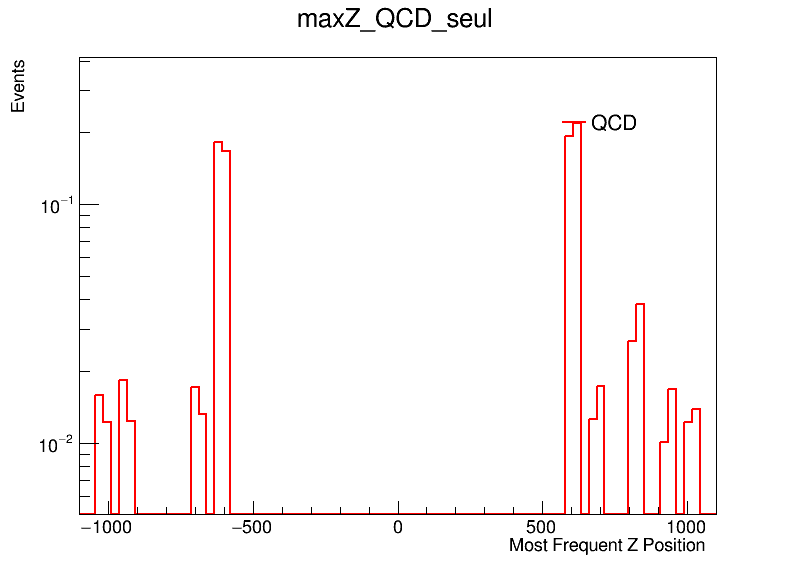

In [92]:
c15 = rt.TCanvas('c15','c15', 800, 600)

h['maxZ_QCD_seul'] = create_TH1D(z_max_occ_prompt['total'], axis_title=['Most Frequent Z Position', 'Events'], name='maxZ_QCD_seul', binning=[80, -1100, 1100])
h['maxZ_QCD_seul'].SetLineColor(2)
# cscT_prompt_rms
c15.SetLogy()

h['maxZ_QCD_seul'].Scale(1.0/h['maxZ_QCD_seul'].Integral())

#h['cscT_dis_rms'].SetLineWidth(2)
#h['cscT_prompt_rms'].SetLineWidth(2)
#h['cscT_dis_rms'].GetXaxis().SetRangeUser(0,20)
h['maxZ_QCD_seul'].GetXaxis().SetRangeUser(-1100,1100)
#h['cscT_dis_rms'].SetLineWidth(2)
h['maxZ_QCD_seul'].SetLineWidth(2)
h['maxZ_QCD_seul'].SetStats(0)
h['maxZ_QCD_seul'].Draw('histo')
#h['cscT_dis_rms'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
#legend.AddEntry( h['cscT_dis_rms'], "Signal" , "L");
legend.AddEntry( h['maxZ_QCD_seul'], "QCD", 'l');
legend.Draw();

c15.Draw()

In [93]:
# ROC Curve for QCD/ggH Signal

# Code
eff_qcd_cluster = np.array([])
eff_signal_cluster = np.array([])

eff_qcd_noCluster = np.array([])
eff_signal_noCluster = np.array([])

for hit_thresh in range(200):
    truth_eff_qcd = np.array(n_c_total_prompt['total'])
    eff_qcd_cluster = np.append(eff_qcd_cluster, np.count_nonzero(np.array(n_c_total_prompt['total'])>hit_thresh)/len(n_c_total_prompt['total']))
    eff_signal_cluster = np.append(eff_signal_cluster, np.count_nonzero(np.array(n_c_total_dis['total'])>hit_thresh)/len(n_c_total_dis['total']))
    eff_qcd_noCluster = np.append(eff_qcd_noCluster, np.count_nonzero(np.array(nCsc_prompt)>hit_thresh)/len(nCsc_prompt))
    eff_signal_noCluster = np.append(eff_signal_noCluster, np.count_nonzero(np.array(nCsc_dis)>hit_thresh)/len(nCsc_dis))

print(len(eff_qcd_noCluster))
print(len(eff_signal_noCluster))
    # print(eff_qcd)

200
200


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c16


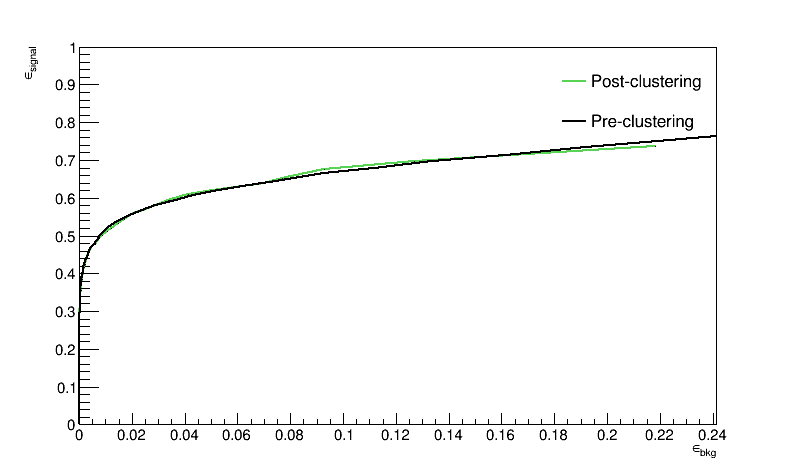

In [94]:
# Graph Implementation

c16 = rt.TCanvas('c16','c16', 800, 500)

# Plots clustered version of nCsc:gLLP_decay_vertex_z
h['roc_curve_cluster'] = create_TGraph(eff_qcd_cluster, eff_signal_cluster, axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_noCluster'] = create_TGraph(eff_qcd_noCluster, eff_signal_noCluster, axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])

c16.SetLogz()
# h['roc_curve'].SetStats(0)
h['roc_curve_cluster'].SetTitle('')
h['roc_curve_cluster'].SetLineWidth(2)
h['roc_curve_noCluster'].SetLineWidth(2)

h['roc_curve_cluster'].SetLineColor(8)
h['roc_curve_cluster'].GetXaxis().SetRangeUser(0,1)
h['roc_curve_cluster'].GetYaxis().SetRangeUser(0,1)
#c4.cd()
#h['eta_phi_0'].SetStats(0)



h['roc_curve_cluster'].Draw()
h['roc_curve_noCluster'].Draw('same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);
legend.AddEntry( h['roc_curve_cluster'], "Post-clustering", 'l');
legend.AddEntry( h['roc_curve_noCluster'], "Pre-clustering", 'l');

legend.Draw();


c16.Draw()
#c5.SaveAs("nCsc_gLLPdecayVertZ.pdf")
#c5.SaveAs("nCsc_gLLPdecayVertZ.C")